# Cancer Nuclei Analysis with EfficientNet

**Project:** CSC173 Deep Vision Final Project  
**Student:** Emmanuel Fitz C. Ciano, 2022-0154  
**Date:** December 2025

## Project Overview
This notebook implements a binary segmentation model for cancer nuclei detection in histopathology images using EfficientNet-B0 as the backbone. The model performs:
- **Binary Segmentation:** Distinguishing cancer cells from background in histopathology images
- **Image Classification:** Binary classification to identify images containing cancer cells
- **Model Evaluation:** Comprehensive metrics including Dice coefficient, IoU, and per-class accuracy

The dataset consists of histopathology images with binary masks (cancer vs background). The model uses a U-Net architecture with EfficientNet-B0 encoder for feature extraction and a decoder for segmentation output.


## Model Configuration

This notebook uses EfficientNet-B0 as the backbone architecture for binary cancer nuclei segmentation. The model configuration includes:

- **Image Resolution**: 128x128 pixels
- **Model Architecture**: U-Net with EfficientNet-B0 encoder for binary segmentation
- **Training**: Mixed precision training with GPU acceleration when available
- **Data Augmentation**: Rotations, flips, color jitter, and affine transforms
- **Loss Functions**: Combined Dice+BCE for binary segmentation

---


In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF

import torchvision.models as models
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from scipy import ndimage
from skimage import measure, morphology

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import random

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True  
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    from torch.cuda.amp import autocast, GradScaler
    use_amp = True
    scaler = GradScaler()  # Initialize gradient scaler for mixed precision
    print(f"Mixed Precision (AMP) enabled")
else:
    device = torch.device('cpu')
    use_amp = False
    scaler = None  # No scaler needed for CPU
    print("WARNING: CUDA not available, using CPU")
    print("Please ensure CUDA and PyTorch with CUDA support are installed")

print(f"Device: {device}")


Using GPU: NVIDIA GeForce RTX 3050
CUDA Version: 12.1
GPU Memory: 8.59 GB
Mixed Precision (AMP) enabled
Device: cuda


In [30]:
dataset_root = Path("Dataset")
images_path = dataset_root / "Images" / "images.npy"
masks_path = dataset_root / "Masks" / "masks.npy"
types_path = dataset_root / "Images" / "types.npy"

import cv2
print("Loading dataset...")
images = np.load(images_path, mmap_mode='r')
masks = np.load(masks_path, mmap_mode='r')
types = np.load(types_path, mmap_mode='r')

print("Downsampling images from 256x256 to 128x128...")
images_downsampled = np.zeros((images.shape[0], 128, 128, 3), dtype=np.float32)
masks_downsampled = np.zeros((masks.shape[0], 128, 128, masks.shape[-1]), dtype=np.float32)

for i in tqdm(range(len(images)), desc="Downsampling"):
    img_uint8 = images[i].astype(np.uint8)
    img_down = cv2.resize(img_uint8, (128, 128), interpolation=cv2.INTER_AREA)
    images_downsampled[i] = img_down.astype(np.float32)
    
    for c in range(masks.shape[-1]):
        mask_channel = masks[i, :, :, c].astype(np.uint8)
        mask_down = cv2.resize(mask_channel, (128, 128), interpolation=cv2.INTER_NEAREST)
        masks_downsampled[i, :, :, c] = mask_down.astype(np.float32)

images = images_downsampled
masks = masks_downsampled
del images_downsampled, masks_downsampled
print("Images downsampled to 128x128")

print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")
print(f"Types shape: {types.shape}")
print(f"Images dtype: {images.dtype}, range: [{images.min()}, {images.max()}]")
print(f"Masks dtype: {masks.dtype}, unique values: {np.unique(masks)}")


Loading dataset...
Downsampling images from 256x256 to 128x128...


Downsampling: 100%|██████████| 2656/2656 [00:53<00:00, 49.26it/s]


Images downsampled to 128x128
Images shape: (2656, 128, 128, 3)
Masks shape: (2656, 128, 128, 6)
Types shape: (2656,)
Images dtype: float32, range: [0.0, 255.0]
Masks dtype: float32, unique values: [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 

In [31]:
print("=" * 60)
print("DATASET STATISTICS")
print("=" * 60)
print(f"Total number of images: {len(images)}")
print(f"Image dimensions: {images.shape[1]}x{images.shape[2]}")
print(f"Number of channels: {images.shape[3] if len(images.shape) > 3 else 1}")

mask_classes = {
    0: "Neoplastic cells",
    1: "Inflammatory",
    2: "Connective/Soft tissue cells",
    3: "Dead Cells",
    4: "Epithelial",
    5: "Background"
}

print(f"\nMask channels: {masks.shape[-1]}")
print("Mask class mapping:")
for idx, name in mask_classes.items():
    if idx < masks.shape[-1]:
        count = np.sum(masks[:, :, :, idx] > 0)
        print(f"  Channel {idx}: {name} - {count} instances")

print("\nInstance counts per class:")
for class_idx in range(masks.shape[-1]):
    instance_count = 0
    for img_idx in range(len(masks)):
        binary_mask = masks[img_idx, :, :, class_idx] > 0
        if binary_mask.any():
            labeled = measure.label(binary_mask)
            instance_count += labeled.max()
    if class_idx in mask_classes:
        print(f"  Class {class_idx} ({mask_classes[class_idx]}): ~{instance_count} instances")
    else:
        print(f"  Class {class_idx}: ~{instance_count} instances")


DATASET STATISTICS
Total number of images: 2656
Image dimensions: 128x128
Number of channels: 3

Mask channels: 6
Mask class mapping:
  Channel 0: Neoplastic cells - 3917499 instances
  Channel 1: Inflammatory - 775774 instances
  Channel 2: Connective/Soft tissue cells - 1606063 instances
  Channel 3: Dead Cells - 28347 instances
  Channel 4: Epithelial - 1064999 instances
  Channel 5: Background - 35517484 instances

Instance counts per class:
  Class 0 (Neoplastic cells): ~20133 instances
  Class 1 (Inflammatory): ~8847 instances
  Class 2 (Connective/Soft tissue cells): ~14569 instances
  Class 3 (Dead Cells): ~871 instances
  Class 4 (Epithelial): ~6564 instances
  Class 5 (Background): ~4535 instances


MASK DIAGNOSTICS - Neoplastic Cells (Channel 0)

Image 0:
  Mask shape: (128, 128)
  Mask dtype: float32
  Min value: 0.0
  Max value: 40.0
  Unique values count: 5
  Non-zero pixels: 1090 (6.65%)
  Zero pixels: 15294 (93.35%)
  Non-zero value range: [3.0, 40.0]

Image 1:
  Mask shape: (128, 128)
  Mask dtype: float32
  Min value: 0.0
  Max value: 159.0
  Unique values count: 9
  Non-zero pixels: 1991 (12.15%)
  Zero pixels: 14393 (87.85%)
  Non-zero value range: [1.0, 159.0]

Image 2:
  Mask shape: (128, 128)
  Mask dtype: float32
  Min value: 0.0
  Max value: 42.0
  Unique values count: 9
  Non-zero pixels: 2953 (18.02%)
  Zero pixels: 13431 (81.98%)
  Non-zero value range: [6.0, 42.0]


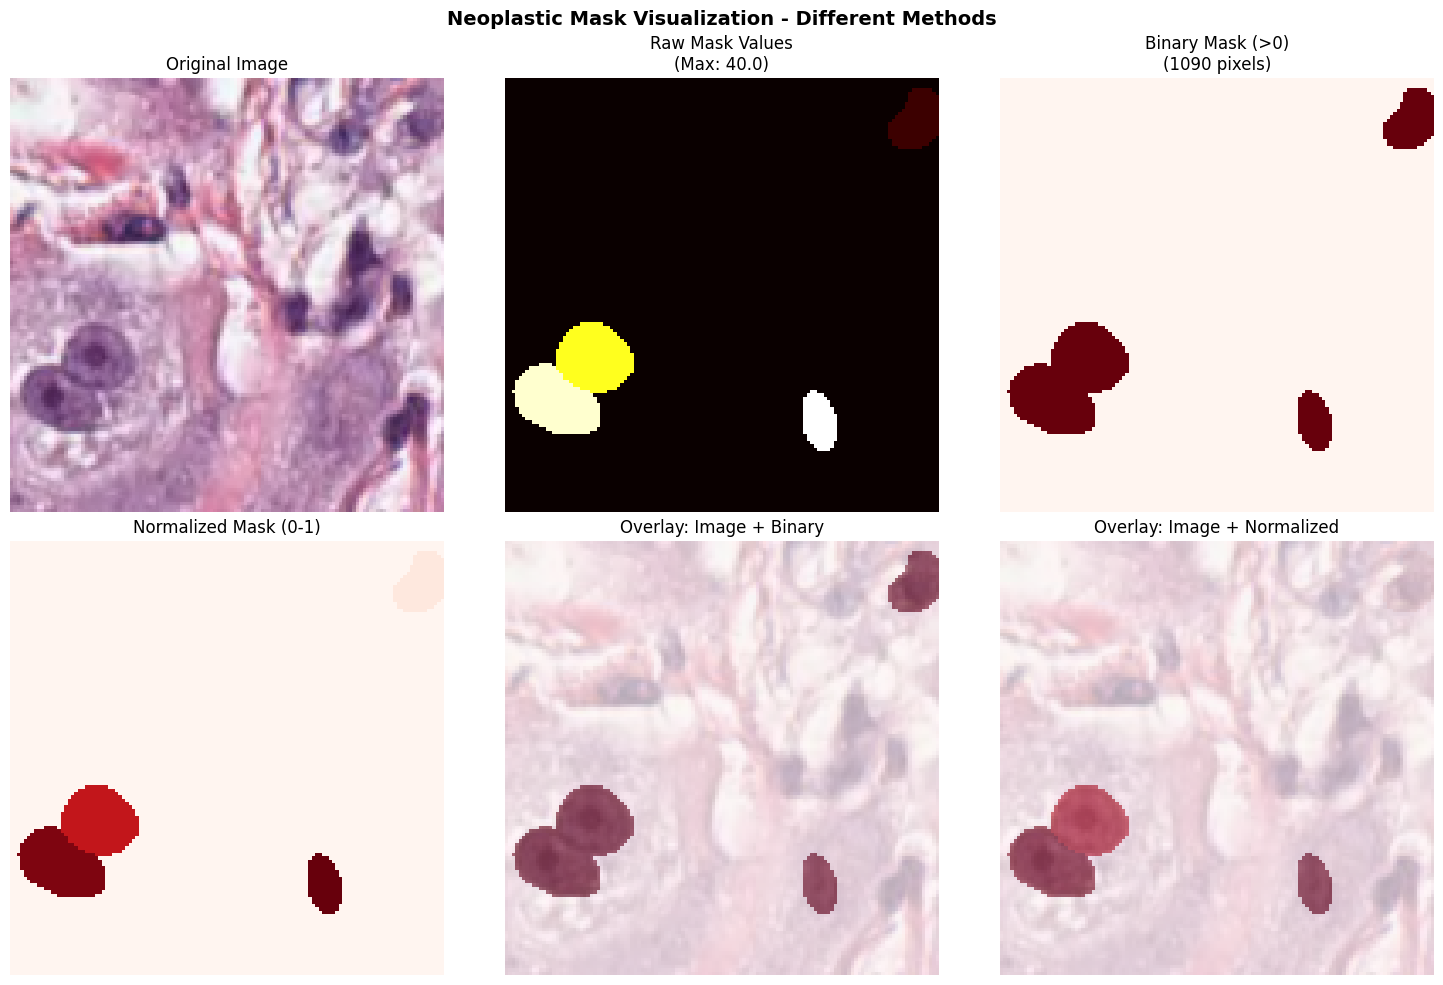


If masks appear empty or single-colored, check:
1. Are there actually neoplastic cells in these images?
2. Are mask values instance IDs (0, 1, 2, ...) or binary (0, 1)?
3. Try different sample images - some may not have neoplastic cells


In [32]:
print("=" * 60)
print("MASK DIAGNOSTICS - Neoplastic Cells (Channel 0)")
print("=" * 60)

for test_idx in [0, 1, 2]:
    neoplastic_mask = masks[test_idx, :, :, 0]
    
    print(f"\nImage {test_idx}:")
    print(f"  Mask shape: {neoplastic_mask.shape}")
    print(f"  Mask dtype: {neoplastic_mask.dtype}")
    print(f"  Min value: {neoplastic_mask.min()}")
    print(f"  Max value: {neoplastic_mask.max()}")
    print(f"  Unique values count: {len(np.unique(neoplastic_mask))}")
    print(f"  Non-zero pixels: {np.sum(neoplastic_mask > 0)} ({100 * np.sum(neoplastic_mask > 0) / neoplastic_mask.size:.2f}%)")
    print(f"  Zero pixels: {np.sum(neoplastic_mask == 0)} ({100 * np.sum(neoplastic_mask == 0) / neoplastic_mask.size:.2f}%)")
    
    if neoplastic_mask.max() > 0:
        print(f"  Non-zero value range: [{neoplastic_mask[neoplastic_mask > 0].min():.1f}, {neoplastic_mask.max():.1f}]")
    else:
        print(f"  WARNING: No neoplastic cells detected in this image!")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Neoplastic Mask Visualization - Different Methods', fontsize=14, fontweight='bold')

test_idx = 0
neoplastic_mask = masks[test_idx, :, :, 0]
img = images[test_idx]
if img.max() > 1.0:
    img = img / 255.0

axes[0, 0].imshow(img)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(neoplastic_mask, cmap='hot')
axes[0, 1].set_title(f'Raw Mask Values\n(Max: {neoplastic_mask.max():.1f})')
axes[0, 1].axis('off')

binary_mask = neoplastic_mask > 0
axes[0, 2].imshow(binary_mask, cmap='Reds')
axes[0, 2].set_title(f'Binary Mask (>0)\n({np.sum(binary_mask)} pixels)')
axes[0, 2].axis('off')

if neoplastic_mask.max() > 0:
    normalized_mask = neoplastic_mask / neoplastic_mask.max()
else:
    normalized_mask = neoplastic_mask
axes[1, 0].imshow(normalized_mask, cmap='Reds', vmin=0, vmax=1)
axes[1, 0].set_title('Normalized Mask (0-1)')
axes[1, 0].axis('off')

axes[1, 1].imshow(img, alpha=0.7)
axes[1, 1].imshow(binary_mask, cmap='Reds', alpha=0.5)
axes[1, 1].set_title('Overlay: Image + Binary')
axes[1, 1].axis('off')

axes[1, 2].imshow(img, alpha=0.7)
axes[1, 2].imshow(normalized_mask, cmap='Reds', alpha=0.5, vmin=0, vmax=1)
axes[1, 2].set_title('Overlay: Image + Normalized')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("If masks appear empty or single-colored, check:")
print("1. Are there actually neoplastic cells in these images?")
print("2. Are mask values instance IDs (0, 1, 2, ...) or binary (0, 1)?")
print("3. Try different sample images - some may not have neoplastic cells")
print("=" * 60)


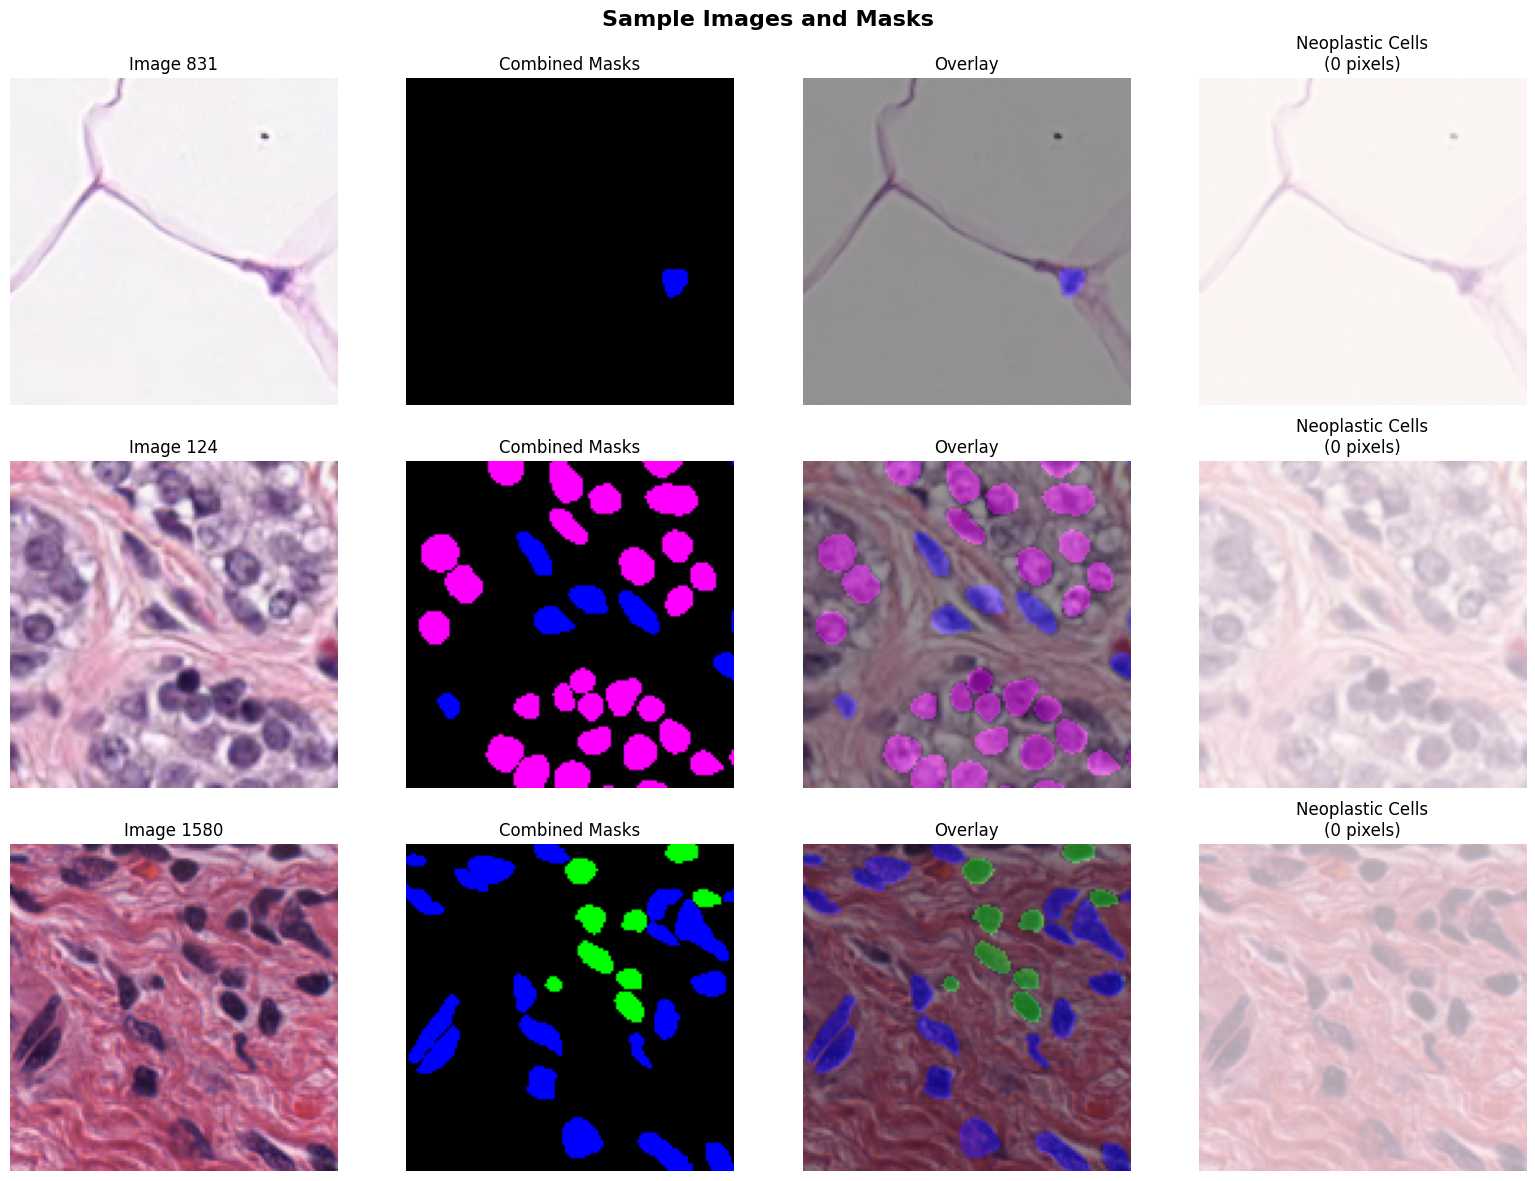

In [33]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle("Sample Images and Masks", fontsize=16, fontweight='bold')

sample_indices = np.random.choice(len(images), 3, replace=False)

for i, idx in enumerate(sample_indices):
    img = images[idx]
    if img.max() > 1.0:
        img = img / 255.0
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Image {idx}")
    axes[i, 0].axis('off')
    
    combined_mask = np.zeros((masks.shape[1], masks.shape[2], 3))
    colors = [
        [1, 0, 0],      # Neoplastic - Red
        [0, 1, 0],      # Inflammatory - Green
        [0, 0, 1],      # Connective - Blue
        [1, 1, 0],      # Dead Cells - Yellow
        [1, 0, 1],      # Epithelial - Magenta
    ]
    
    for class_idx in range(min(5, masks.shape[-1])):
        mask_channel = masks[idx, :, :, class_idx] > 0
        combined_mask[mask_channel] = colors[class_idx]
    
    axes[i, 1].imshow(combined_mask)
    axes[i, 1].set_title("Combined Masks")
    axes[i, 1].axis('off')
    
    overlay = img * 0.6 + combined_mask * 0.4
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title("Overlay")
    axes[i, 2].axis('off')
    
    neoplastic_mask = masks[idx, :, :, 0]
    if neoplastic_mask.max() > 0:
        neoplastic_mask_normalized = neoplastic_mask / neoplastic_mask.max()
    else:
        neoplastic_mask_normalized = neoplastic_mask
    
    axes[i, 3].imshow(img, alpha=0.7)
    axes[i, 3].imshow(neoplastic_mask_normalized, cmap='Reds', alpha=0.5, vmin=0, vmax=1)
    axes[i, 3].set_title(f"Neoplastic Cells\n({np.sum(neoplastic_mask > 0)} pixels)")
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()


In [34]:
def extract_instances_from_mask(mask_channels, min_area=10):
    """
    Extract individual instances from mask channels.
    Returns list of (bbox, class_id, mask) for each instance.
    """
    instances = []
    
    if len(mask_channels.shape) == 3:
        if mask_channels.shape[0] < mask_channels.shape[-1]:
            num_channels = mask_channels.shape[-1]
            get_channel = lambda idx: mask_channels[:, :, idx]
        else:
            num_channels = mask_channels.shape[0]
            get_channel = lambda idx: mask_channels[idx]
    else:
        raise ValueError(f"Unexpected mask shape: {mask_channels.shape}")
    
    for class_idx in range(min(5, num_channels)):
        binary_mask = get_channel(class_idx) > 0
        
        if not binary_mask.any():
            continue
        
        labeled_mask = measure.label(binary_mask)
        regions = measure.regionprops(labeled_mask)
        
        for region in regions:
            if region.area < min_area:
                continue
            
            min_row, min_col, max_row, max_col = region.bbox
            bbox = [min_col, min_row, max_col, max_row]  # x1, y1, x2, y2
            
            instance_mask = (labeled_mask == region.label).astype(np.float32)
            
            instances.append({
                'bbox': bbox,
                'class_id': class_idx,
                'mask': instance_mask,
                'area': region.area
            })
    
    return instances

test_idx = 0
test_instances = extract_instances_from_mask(masks[test_idx])
print(f"Image {test_idx} has {len(test_instances)} instances")
print(f"\nFirst 5 instances:")
for i, inst in enumerate(test_instances[:5]):
    print(f"  Instance {i}: Class {inst['class_id']} ({mask_classes[inst['class_id']]}), "
          f"Area: {inst['area']}, BBox: {inst['bbox']}")


Image 0 has 5 instances

First 5 instances:
  Instance 0: Class 0 (Neoplastic cells), Area: 128.0, BBox: [5, 0, 6, 128]
  Instance 1: Class 1 (Inflammatory), Area: 128.0, BBox: [5, 0, 6, 128]
  Instance 2: Class 2 (Connective/Soft tissue cells), Area: 128.0, BBox: [5, 0, 6, 128]
  Instance 3: Class 3 (Dead Cells), Area: 120.0, BBox: [5, 0, 6, 120]
  Instance 4: Class 4 (Epithelial), Area: 119.0, BBox: [5, 0, 6, 119]


In [35]:
def normalize_image(img):
    """Normalize image to [0, 1] range."""
    if img.max() > 1.0:
        img = img.astype(np.float32) / 255.0
    return img.astype(np.float32)

images_normalized = np.array([normalize_image(img) for img in images])
print(f"Normalized images shape: {images_normalized.shape}")
print(f"Normalized range: [{images_normalized.min():.3f}, {images_normalized.max():.3f}]")

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
print(f"\nWill use ImageNet normalization:")
print(f"  Mean: {IMAGENET_MEAN}")
print(f"  Std: {IMAGENET_STD}")


Normalized images shape: (2656, 128, 128, 3)
Normalized range: [0.000, 1.000]

Will use ImageNet normalization:
  Mean: [0.485, 0.456, 0.406]
  Std: [0.229, 0.224, 0.225]


DATA PIPELINE VERIFICATION

1. Checking mask values:
  Sample 0: Unique mask values: [ 0.  1.  3. 18. 19. 28. 31. 38. 40. 41.]
    Mask shape: (128, 128, 6), dtype: float32
    Value range: [0.0, 41.0]
    Is integer: True, In range [0-5]: False
  Sample 1: Unique mask values: [  0.   1.   3.   8.  24.  27.  29.  35.  39.  43. 159.]
    Mask shape: (128, 128, 6), dtype: float32
    Value range: [0.0, 159.0]
    Is integer: True, In range [0-5]: False
  Sample 2: Unique mask values: [ 0.  1.  6.  8. 10. 11. 15. 21. 22. 30. 34. 42. 48.]
    Mask shape: (128, 128, 6), dtype: float32
    Value range: [0.0, 48.0]
    Is integer: True, In range [0-5]: False
  Sample 3: Unique mask values: [ 0.  1.  4.  9. 14. 17. 23. 26. 33. 36. 46. 49.]
    Mask shape: (128, 128, 6), dtype: float32
    Value range: [0.0, 49.0]
    Is integer: True, In range [0-5]: False
  Sample 4: Unique mask values: [  0.   1.  58.  60.  64.  70.  81.  82. 156.]
    Mask shape: (128, 128, 6), dtype: float32
    Value rang

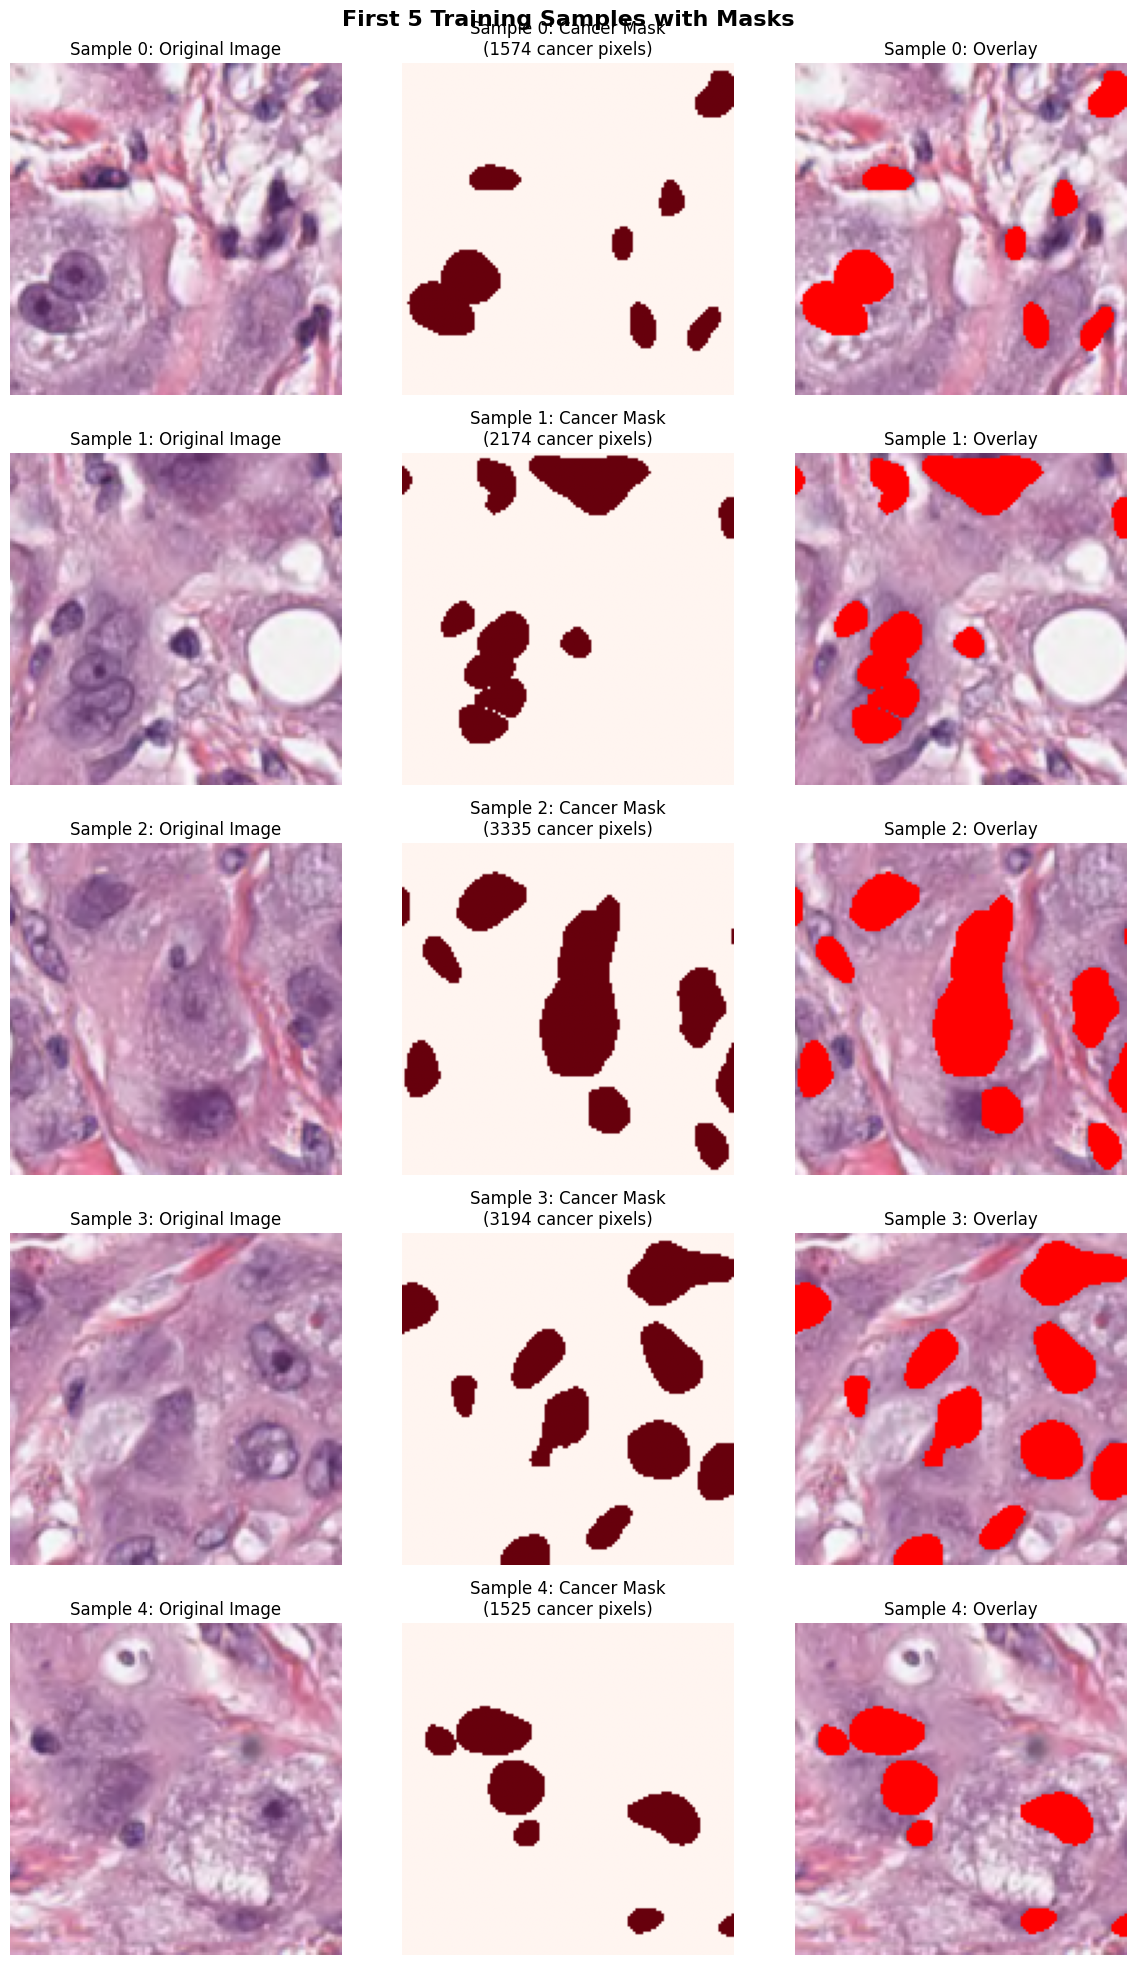


2. ImageNet normalization will be applied:
   Mean: [0.485, 0.456, 0.406]
   Std: [0.229, 0.224, 0.225]

✓ Data pipeline verified!


In [36]:
print("=" * 60)
print("DATA PIPELINE VERIFICATION")
print("=" * 60)

print("\n1. Checking mask values:")
for i in range(min(5, len(masks))):
    mask_sample = masks[i]
    unique_vals = np.unique(mask_sample)
    print(f"  Sample {i}: Unique mask values: {unique_vals}")
    print(f"    Mask shape: {mask_sample.shape}, dtype: {mask_sample.dtype}")
    print(f"    Value range: [{mask_sample.min()}, {mask_sample.max()}]")
    is_integer = np.allclose(mask_sample, np.round(mask_sample))
    in_range = (mask_sample.min() >= 0) and (mask_sample.max() <= 5)
    print(f"    Is integer: {is_integer}, In range [0-5]: {in_range}")

fig, axes = plt.subplots(5, 3, figsize=(12, 20))
fig.suptitle('First 5 Training Samples with Masks', fontsize=16, fontweight='bold')

for i in range(min(5, len(images_normalized))):
    img = images_normalized[i]
    mask_channels = masks[i]
    
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'Sample {i}: Original Image')
    axes[i, 0].axis('off')
    
    cancer_mask = (mask_channels[:, :, :5].sum(axis=2) > 0).astype(np.float32)
    axes[i, 1].imshow(cancer_mask, cmap='Reds')
    axes[i, 1].set_title(f'Sample {i}: Cancer Mask\n({cancer_mask.sum():.0f} cancer pixels)')
    axes[i, 1].axis('off')
    
    overlay = img.copy()
    overlay[cancer_mask > 0] = [1.0, 0.0, 0.0]  # Red overlay for cancer
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title(f'Sample {i}: Overlay')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n2. ImageNet normalization will be applied:")
print(f"   Mean: {IMAGENET_MEAN}")
print(f"   Std: {IMAGENET_STD}")
print("\n✓ Data pipeline verified!")


In [37]:
class CancerNucleiDataset(Dataset):
    """
    Dataset for binary cancer nuclei segmentation (cancer vs background).
    Uses 128x128 images with ImageNet normalization.
    """
    def __init__(self, images, masks, transform=None, img_size=128, binary_mode=True):
        self.images = images
        self.masks = masks
        self.transform = transform
        self.img_size = img_size
        self.binary_mode = binary_mode  # True: binary (cancer vs background), False: 6 classes
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].copy()
        mask_channels = self.masks[idx].copy()  # [H, W, 6] - 6 channels for 6 classes
        
        if image.max() > 1.0:
            image = image / 255.0
        
        image_pil = Image.fromarray((image * 255).astype(np.uint8))
        
        if self.transform:
            image_pil = self.transform(image_pil)
        
        image = TF.to_tensor(image_pil)  # Converts to [0, 1] and CHW
        image = TF.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        if image.shape[1] != self.img_size or image.shape[2] != self.img_size:
            image = F.interpolate(image.unsqueeze(0), size=(self.img_size, self.img_size), 
                                 mode='bilinear', align_corners=False).squeeze(0)
        
        if self.binary_mode:
            cancer_mask = (mask_channels[:, :, :5].sum(axis=2) > 0).astype(np.float32)  # [H, W]
            if cancer_mask.shape[0] != self.img_size or cancer_mask.shape[1] != self.img_size:
                cancer_mask_tensor = torch.from_numpy(cancer_mask).float().unsqueeze(0)
                cancer_mask_tensor = F.interpolate(cancer_mask_tensor.unsqueeze(0), 
                                                  size=(self.img_size, self.img_size),
                                                  mode='nearest').squeeze(0).squeeze(0)
                mask = cancer_mask_tensor.numpy()
            else:
                mask = cancer_mask
            mask = torch.from_numpy(mask).float()  # [H, W]
            class_mask = mask.long()  # Binary: 0=background, 1=cancer
        else:
            class_mask = np.argmax(mask_channels, axis=2).astype(np.int64)  # [H, W]
            if class_mask.shape[0] != self.img_size or class_mask.shape[1] != self.img_size:
                class_mask_tensor = torch.from_numpy(class_mask).long().unsqueeze(0)
                class_mask_tensor = F.interpolate(class_mask_tensor.float().unsqueeze(0), 
                                                 size=(self.img_size, self.img_size),
                                                 mode='nearest').squeeze(0).squeeze(0).long()
                class_mask = class_mask_tensor.numpy()
            mask = torch.from_numpy(class_mask).long()
            class_mask = mask
        
        return {
            'image': image,  # [3, H, W] - ImageNet normalized
            'mask': mask,  # [H, W] - Binary or multi-class
            'class_mask': class_mask,  # [H, W] - For loss computation
            'idx': idx
        }


In [38]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

val_transform = None

train_indices, val_indices = train_test_split(
    range(len(images_normalized)), 
    test_size=0.2, 
    random_state=42
)

print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")

train_dataset = CancerNucleiDataset(
    images_normalized[train_indices],
    masks[train_indices],
    transform=train_transform,
    img_size=128,
    binary_mode=True  # Binary: cancer vs background
)

val_dataset = CancerNucleiDataset(
    images_normalized[val_indices],
    masks[val_indices],
    transform=val_transform,
    img_size=128,
    binary_mode=True
)

sample = train_dataset[0]
print(f"\nDataset sample:")
print(f"  Image shape: {sample['image'].shape}")
print(f"  Mask shape: {sample['mask'].shape}")
print(f"  Class mask shape: {sample['class_mask'].shape}")
print(f"  Mask unique values: {torch.unique(sample['class_mask'])}")
print(f"  Cancer pixels: {(sample['class_mask'] == 1).sum().item()}")
print(f"  Background pixels: {(sample['class_mask'] == 0).sum().item()}")

print("\nCalculating class distribution...")
all_masks = []
for i in tqdm(range(len(train_dataset)), desc="Counting classes"):
    sample = train_dataset[i]
    all_masks.append(sample['class_mask'].numpy())
all_masks = np.concatenate([m.flatten() for m in all_masks])

class_counts = np.bincount(all_masks, minlength=2)  # Binary: 0=background, 1=cancer
print(f"  Background (0): {class_counts[0]:,} pixels")
print(f"  Cancer (1): {class_counts[1]:,} pixels")
print(f"  Ratio (background/cancer): {class_counts[0]/class_counts[1]:.2f}")

class_weights = 1.0 / np.sqrt(class_counts + 1e-6)
class_weights = class_weights / class_weights.sum() * len(class_weights)  # Normalize
print(f"\nClass weights: {class_weights}")
class_weights_tensor = torch.FloatTensor(class_weights).to(device)


Training samples: 2124
Validation samples: 532

Dataset sample:
  Image shape: torch.Size([3, 128, 128])
  Mask shape: torch.Size([128, 128])
  Class mask shape: torch.Size([128, 128])
  Mask unique values: tensor([0, 1])
  Cancer pixels: 5698
  Background pixels: 10686

Calculating class distribution...


Counting classes: 100%|██████████| 2124/2124 [00:01<00:00, 1313.52it/s]


  Background (0): 28,900,348 pixels
  Cancer (1): 5,899,268 pixels
  Ratio (background/cancer): 4.90

Class weights: [0.62240106 1.37759894]


In [39]:
print("Datasets already created above. Skipping re-creation.")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Image size: 128x128")
print(f"Mode: Binary classification (cancer vs background)")


Datasets already created above. Skipping re-creation.
Training samples: 2124
Validation samples: 532
Image size: 128x128
Mode: Binary classification (cancer vs background)


In [40]:
class UNetEfficientNet(nn.Module):
    """
    U-Net with EfficientNet-B0 encoder for binary segmentation.
    Lightweight and memory-efficient for 8GB GPUs.
    """
    def __init__(self, num_classes=1, freeze_encoder=True):
        super().__init__()
        self.num_classes = num_classes
        
        backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.encoder = backbone.features
        
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
        
        self.enc_channels = [24, 40, 112, 192, 1280]
        
        self.dec4 = self._make_decoder_block(1280, 192, 192)
        self.dec3 = self._make_decoder_block(192 + 192, 112, 112)  # +skip from enc
        self.dec2 = self._make_decoder_block(112 + 112, 40, 40)
        self.dec1 = self._make_decoder_block(40 + 40, 24, 24)
        self.dec0 = self._make_decoder_block(24 + 24, 16, 16)
        
        self.final_conv = nn.Conv2d(16, num_classes, kernel_size=1)
        
        self._init_weights()
    
    def _make_decoder_block(self, in_channels, mid_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        enc0 = self.encoder[0](x)  # [B, 24, H/2, W/2]
        enc1 = self.encoder[1](enc0)  # [B, 24, H/2, W/2]
        enc2 = self.encoder[2](enc1)  # [B, 40, H/4, W/4]
        enc3 = self.encoder[3](enc2)  # [B, 112, H/8, W/8]
        enc4 = self.encoder[4](enc3)  # [B, 192, H/16, W/16]
        enc5 = self.encoder[5](enc4)  # [B, 192, H/16, W/16]
        enc6 = self.encoder[6](enc5)  # [B, 1280, H/32, W/32]
        
        B, C, H, W = x.shape
        
        dec4 = F.interpolate(enc6, size=(H//16, W//16), mode='bilinear', align_corners=False)
        dec4 = self.dec4(torch.cat([dec4, enc5], dim=1))
        
        dec3 = F.interpolate(dec4, size=(H//8, W//8), mode='bilinear', align_corners=False)
        dec3 = self.dec3(torch.cat([dec3, enc3], dim=1))
        
        dec2 = F.interpolate(dec3, size=(H//4, W//4), mode='bilinear', align_corners=False)
        dec2 = self.dec2(torch.cat([dec2, enc2], dim=1))
        
        dec1 = F.interpolate(dec2, size=(H//2, W//2), mode='bilinear', align_corners=False)
        dec1 = self.dec1(torch.cat([dec1, enc1], dim=1))
        
        dec0 = F.interpolate(dec1, size=(H, W), mode='bilinear', align_corners=False)
        dec0 = self.dec0(torch.cat([dec0, enc0], dim=1))
        
        output = self.final_conv(dec0)  # [B, num_classes, H, W]
        
        return output
    
    def unfreeze_encoder(self):
        """Unfreeze encoder for fine-tuning."""
        for param in self.encoder.parameters():
            param.requires_grad = True

print("U-Net with EfficientNet-B0 encoder defined")


U-Net with EfficientNet-B0 encoder defined


In [53]:
class EfficientNetSegmentation(nn.Module):
    """
    EfficientNet-B0 based model for instance segmentation and classification.
    Uses EfficientNet-B0 as backbone with multi-task heads for segmentation, classification, and bbox prediction.
    """
    def __init__(self, 
                 img_size=128,
                 in_channels=3,
                 num_classes=5,
                 dropout=0.2,
                 max_instances=50,
                 freeze_backbone=False):
        super().__init__()
        
        self.img_size = img_size
        self.num_classes = num_classes
        self.max_instances = max_instances
        
        backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.backbone_features = backbone.features
        
        if freeze_backbone:
            for param in self.backbone_features.parameters():
                param.requires_grad = False
        
        backbone_dim = 1280
        
        self.decoder1 = nn.Sequential(
            nn.Conv2d(backbone_dim, backbone_dim // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(backbone_dim // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(backbone_dim // 2, backbone_dim // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(backbone_dim // 2),
            nn.ReLU(inplace=True)
        )
        
        self.decoder2 = nn.Sequential(
            nn.Conv2d(backbone_dim // 2, backbone_dim // 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(backbone_dim // 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(backbone_dim // 4, backbone_dim // 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(backbone_dim // 4),
            nn.ReLU(inplace=True)
        )
        
        self.attention = nn.Sequential(
            nn.Conv2d(backbone_dim // 4, backbone_dim // 8, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(backbone_dim // 8, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(backbone_dim // 4 + 1, backbone_dim // 8, kernel_size=3, padding=1),  # +1 for attention
            nn.BatchNorm2d(backbone_dim // 8),
            nn.ReLU(inplace=True),
            nn.Conv2d(backbone_dim // 8, 1, kernel_size=1)  # Binary segmentation: 1 channel
        )
        
        self.instance_head = nn.Sequential(
            nn.Linear(backbone_dim, backbone_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(backbone_dim // 2, backbone_dim // 4),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
        )
        
        self.classification_head = nn.Sequential(
            nn.Linear(backbone_dim // 4, backbone_dim // 8),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(backbone_dim // 8, num_classes)
        )
        
        self.bbox_head = nn.Sequential(
            nn.Linear(backbone_dim // 4, backbone_dim // 8),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(backbone_dim // 8, 4)  # x1, y1, x2, y2
        )
        
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights for custom layers."""
        for module in [self.decoder1, self.decoder2, self.attention, self.segmentation_head]:
            for m in module.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
        
        for m in [self.instance_head, self.classification_head, self.bbox_head]:
            for layer in m:
                if isinstance(layer, nn.Linear):
                    nn.init.normal_(layer.weight, std=0.02)
                    if layer.bias is not None:
                        nn.init.constant_(layer.bias, 0)
    
    def forward(self, x, return_attention=False):
        """
        Forward pass.
        Args:
            x: Input images [B, C, H, W]
            return_attention: Whether to return attention weights (for compatibility)
        Returns:
            Dictionary with segmentation, classification, and bbox predictions
        """
        B, C, H, W = x.shape
        
        x = torch.clamp(x, min=-10.0, max=10.0)
        x = torch.where(torch.isfinite(x), x, torch.zeros_like(x))
        
        features = self.backbone_features(x)  
        features = torch.clamp(features, min=-1e6, max=1e6)
        features = torch.where(torch.isfinite(features), features, torch.zeros_like(features))
        features = F.interpolate(features, size=(H, W), mode='bilinear', align_corners=False)
        patch_features = features  
        
        x = self.decoder1(features)  
        x = torch.clamp(x, min=-1e6, max=1e6)
        x = torch.where(torch.isfinite(x), x, torch.zeros_like(x))
        
        x = self.decoder2(x)  
        x = torch.clamp(x, min=-1e6, max=1e6)
        x = torch.where(torch.isfinite(x), x, torch.zeros_like(x))
        
   
        att_map = self.attention(x) 
        att_map = torch.clamp(att_map, min=0.0, max=1.0) 
        att_map = torch.where(torch.isfinite(att_map), att_map, torch.zeros_like(att_map))
        
        x_att = torch.cat([x, att_map], dim=1)  
        
        binary_segmentation = self.segmentation_head(x_att) 
        binary_segmentation = torch.clamp(binary_segmentation, min=-100.0, max=100.0)  
        binary_segmentation = torch.where(torch.isfinite(binary_segmentation), binary_segmentation, torch.zeros_like(binary_segmentation))
        
        global_features = F.adaptive_avg_pool2d(features, 1).view(B, -1)  
        global_features = torch.clamp(global_features, min=-1e6, max=1e6)
        global_features = torch.where(torch.isfinite(global_features), global_features, torch.zeros_like(global_features))
        
        instance_features = self.instance_head(global_features)  
        instance_features = torch.clamp(instance_features, min=-1e6, max=1e6)
        instance_features = torch.where(torch.isfinite(instance_features), instance_features, torch.zeros_like(instance_features))
        
        class_logits = self.classification_head(instance_features)  
        class_logits = torch.clamp(class_logits, min=-100.0, max=100.0)
        class_logits = torch.where(torch.isfinite(class_logits), class_logits, torch.zeros_like(class_logits))
        
        bbox_preds = self.bbox_head(instance_features)  # [B, 4]
        bbox_preds = torch.clamp(bbox_preds, min=-1000.0, max=1000.0)
        bbox_preds = torch.where(torch.isfinite(bbox_preds), bbox_preds, torch.zeros_like(bbox_preds))
        
        result = {
            'binary_segmentation': binary_segmentation,
            'class_logits': class_logits,
            'bbox_preds': bbox_preds,
            'patch_features': patch_features,
        }
        
        if return_attention:
            result['attention_weights'] = att_map
        
        return result
    
    def unfreeze_backbone(self):
        """Unfreeze backbone for fine-tuning."""
        for param in self.backbone_features.parameters():
            param.requires_grad = True

print("EfficientNetSegmentation model defined!")


EfficientNetSegmentation model defined!


In [55]:
model = EfficientNetSegmentation(
    img_size=128,
    in_channels=3,
    num_classes=5,
    dropout=0.2,
    max_instances=50
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model Architecture (128x128 - EfficientNet-B0):")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"\nModel components:")
print(f"  EfficientNet-B0 Backbone: {sum(p.numel() for p in model.backbone_features.parameters()):,} parameters")
print(f"  Decoder: {sum(p.numel() for p in model.decoder1.parameters()) + sum(p.numel() for p in model.decoder2.parameters()):,} parameters")
print(f"  Segmentation Head: {sum(p.numel() for p in model.segmentation_head.parameters()):,} parameters")
print(f"  Instance Head: {sum(p.numel() for p in model.instance_head.parameters()):,} parameters")
print(f"  Classification Head: {sum(p.numel() for p in model.classification_head.parameters()):,} parameters")
print(f"  BBox Head: {sum(p.numel() for p in model.bbox_head.parameters()):,} parameters")

test_input = torch.randn(2, 3, 128, 128).to(device)
with torch.no_grad():
    output = model(test_input)
    print(f"\nForward pass test:")
    print(f"  Input shape: {test_input.shape}")
    print(f"  Binary segmentation shape: {output['binary_segmentation'].shape}")
    print(f"  Class logits shape: {output['class_logits'].shape}")
    print(f"  BBox predictions shape: {output['bbox_preds'].shape}")
    print(f"  Patch features shape: {output['patch_features'].shape}")


Model Architecture (128x128 - EfficientNet-B0):
  Total parameters: 19,480,839
  Trainable parameters: 19,480,839

Model components:
  EfficientNet-B0 Backbone: 4,007,548 parameters
  Decoder: 13,829,760 parameters
  Segmentation Head: 462,881 parameters
  Instance Head: 1,024,960 parameters
  Classification Head: 52,165 parameters
  BBox Head: 52,004 parameters

Forward pass test:
  Input shape: torch.Size([2, 3, 128, 128])
  Binary segmentation shape: torch.Size([2, 1, 128, 128])
  Class logits shape: torch.Size([2, 5])
  BBox predictions shape: torch.Size([2, 4])
  Patch features shape: torch.Size([2, 1280, 128, 128])


In [56]:
if 'model' in globals() and model is not None:
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
else:
    print("Model not initialized. Please run cell 20 first to create the model.")
    total_params = 0
    trainable_params = 0

if hasattr(model, 'backbone_features'):
    print(f"Model Architecture (128x128 - EfficientNet-B0):")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"\nModel components:")
    print(f"  EfficientNet-B0 Backbone: {sum(p.numel() for p in model.backbone_features.parameters()):,} parameters")
    print(f"  Decoder: {sum(p.numel() for p in model.decoder1.parameters()) + sum(p.numel() for p in model.decoder2.parameters()):,} parameters")
    print(f"  Segmentation Head: {sum(p.numel() for p in model.segmentation_head.parameters()):,} parameters")
    print(f"  Instance Head: {sum(p.numel() for p in model.instance_head.parameters()):,} parameters")
    print(f"  Classification Head: {sum(p.numel() for p in model.classification_head.parameters()):,} parameters")
    print(f"  BBox Head: {sum(p.numel() for p in model.bbox_head.parameters()):,} parameters")
    test_input = torch.randn(2, 3, 128, 128).to(device)
else:
    print(f"Model Architecture (224x224):")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    test_input = torch.randn(2, 3, 224, 224).to(device)
with torch.no_grad():
    output = model(test_input)
    print(f"\nForward pass test:")
    print(f"  Input shape: {test_input.shape}")
    print(f"  Binary segmentation shape: {output['binary_segmentation'].shape}")
    print(f"  Class logits shape: {output['class_logits'].shape}")
    print(f"  BBox predictions shape: {output['bbox_preds'].shape}")
    print(f"  Patch features shape: {output['patch_features'].shape}")


Model Architecture (128x128 - EfficientNet-B0):
  Total parameters: 19,480,839
  Trainable parameters: 19,480,839

Model components:
  EfficientNet-B0 Backbone: 4,007,548 parameters
  Decoder: 13,829,760 parameters
  Segmentation Head: 462,881 parameters
  Instance Head: 1,024,960 parameters
  Classification Head: 52,165 parameters
  BBox Head: 52,004 parameters

Forward pass test:
  Input shape: torch.Size([2, 3, 128, 128])
  Binary segmentation shape: torch.Size([2, 1, 128, 128])
  Class logits shape: torch.Size([2, 5])
  BBox predictions shape: torch.Size([2, 4])
  Patch features shape: torch.Size([2, 1280, 128, 128])


In [57]:
class BinarySegLoss(nn.Module):
    """Binary segmentation loss: BCEWithLogits + Dice, supports class weights."""
    def __init__(self, class_weights=None, bce_weight=1.0, dice_weight=1.0, smooth=1.0):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        pos_weight = None
        if class_weights is not None and len(class_weights) == 2:
            pos_weight = torch.tensor([class_weights[1] / class_weights[0]], device=class_weights.device)
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.smooth = smooth
    
    def dice_loss(self, logits, targets):
        probs = torch.sigmoid(logits)
        probs_flat = probs.view(-1)
        targets_flat = targets.view(-1)
        intersection = (probs_flat * targets_flat).sum()
        dice = (2. * intersection + self.smooth) / (probs_flat.sum() + targets_flat.sum() + self.smooth)
        return 1 - dice
    
    def forward(self, logits, targets):
        """Accepts targets as tensor or dict/list containing 'mask'/'class_mask'."""
        while not torch.is_tensor(targets):
            if isinstance(targets, dict):
                targets = targets.get('mask', targets.get('class_mask', targets.get('binary_mask', None)))
                if targets is None:
                    raise ValueError("Targets dict missing 'mask'/'class_mask'/'binary_mask'")
            elif isinstance(targets, (list, tuple)) and len(targets) > 0:
                targets = targets[0]
            else:
                raise ValueError(f"Unexpected target type: {type(targets)}, value: {targets}")
        if targets is None:
            raise ValueError("Targets is None after unwrapping")
        if targets.dim() == 3:
            targets = targets.unsqueeze(1)
        if targets.shape != logits.shape:
            if targets.shape[2:] != logits.shape[2:]:
                targets = F.interpolate(targets, size=logits.shape[2:], mode='nearest')
            if targets.shape != logits.shape:
                raise ValueError(f"Target shape {targets.shape} does not match logits shape {logits.shape}")
        targets = targets.float()
        bce = self.bce(logits, targets)
        dice = self.dice_loss(logits, targets)
        total = self.bce_weight * bce + self.dice_weight * dice
        return total, bce, dice

criterion = BinarySegLoss(class_weights_tensor.to(device)).to(device)
print("BinarySegLoss defined (BCEWithLogits + Dice)")


BinarySegLoss defined (BCEWithLogits + Dice)


In [58]:
import os
import multiprocessing

num_threads = min(4, os.cpu_count() or 1)
torch.set_num_threads(num_threads)
print(f"PyTorch using {num_threads} CPU threads for computation")

os.environ['OMP_NUM_THREADS'] = str(num_threads)
os.environ['MKL_NUM_THREADS'] = str(num_threads)

if os.name == 'nt':
    num_workers = 0
    print("Windows detected: Using num_workers=0 (single process data loading)")
else:
    num_workers = min(4, multiprocessing.cpu_count())
    print(f"Using {num_workers} data loading workers")

print(f"\nParallelization Configuration:")
print(f"  CPU threads (PyTorch): {num_threads}")
print(f"  Data loading workers: {num_workers}")


PyTorch using 4 CPU threads for computation
Windows detected: Using num_workers=0 (single process data loading)

Parallelization Configuration:
  CPU threads (PyTorch): 4
  Data loading workers: 0


In [ ]:
def compute_dice_score(pred_mask, target_mask, threshold=0.5):
    """Dice for binary segmentation (sigmoid if logits)."""
    if isinstance(pred_mask, torch.Tensor):
        pred = torch.sigmoid(pred_mask) if (pred_mask.min() < 0 or pred_mask.max() > 1) else pred_mask
        pred = pred.cpu()
        tgt = target_mask.cpu()
        while pred.dim() > tgt.dim():
            pred = pred.squeeze()
        while tgt.dim() > pred.dim():
            tgt = tgt.squeeze()
        if pred.shape != tgt.shape:
            if len(pred.shape) == 2 and len(tgt.shape) == 2:
                if pred.shape != tgt.shape:
                    tgt = F.interpolate(tgt.unsqueeze(0).unsqueeze(0).float(), 
                                       size=pred.shape, mode='nearest').squeeze()
            else:
                pred = pred.flatten()
                tgt = tgt.flatten()
        pred_binary = (pred > threshold).float()
        tgt_binary = tgt.float()
    else:
        pred = pred_mask
        if pred.min() < 0 or pred.max() > 1:
            pred = 1 / (1 + np.exp(-pred))
        pred = np.array(pred).flatten()
        tgt_binary = np.array(target_mask).flatten()
        pred_binary = (pred > threshold).astype(np.float32)
        tgt_binary = tgt_binary.astype(np.float32)
    
    inter = (pred_binary * tgt_binary).sum()
    union = pred_binary.sum() + tgt_binary.sum()
    if union == 0:
        return 1.0
    dice = float((2.0 * inter) / union)
    return max(0.0, min(1.0, dice))

def compute_iou(pred_mask, target_mask, threshold=0.5):
    """IoU for binary segmentation (sigmoid if logits)."""
    if isinstance(pred_mask, torch.Tensor):
        pred = torch.sigmoid(pred_mask) if (pred_mask.min() < 0 or pred_mask.max() > 1) else pred_mask
        pred = pred.cpu()
        tgt = target_mask.cpu()
        while pred.dim() > tgt.dim():
            pred = pred.squeeze()
        while tgt.dim() > pred.dim():
            tgt = tgt.squeeze()
        if pred.shape != tgt.shape:
            if len(pred.shape) == 2 and len(tgt.shape) == 2:
                if pred.shape != tgt.shape:
                    tgt = F.interpolate(tgt.unsqueeze(0).unsqueeze(0).float(), 
                                       size=pred.shape, mode='nearest').squeeze()
            else:
                pred = pred.flatten()
                tgt = tgt.flatten()
        pred_binary = (pred > threshold).float()
        tgt_binary = tgt.float()
    else:
        pred = pred_mask
        if pred.min() < 0 or pred.max() > 1:
            pred = 1 / (1 + np.exp(-pred))
        pred = np.array(pred).flatten()
        tgt_binary = np.array(target_mask).flatten()
        pred_binary = (pred > threshold).astype(np.float32)
        tgt_binary = tgt_binary.astype(np.float32)
    
    inter = (pred_binary * tgt_binary).sum()
    union = pred_binary.sum() + tgt_binary.sum() - inter
    if union == 0:
        return 1.0
    iou = float(inter / union)
    return max(0.0, min(1.0, iou))

def evaluate_model(model, dataloader, criterion, device, use_amp=False):
    """Evaluate binary segmentation model."""
    model.eval()
    total_loss = 0.0
    dice_scores, iou_scores = [], []
    per_class_correct = [0, 0]
    per_class_total = [0, 0]
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            images = batch['image'].to(device, non_blocking=True)
            
            if torch.isnan(images).any() or torch.isinf(images).any():
                print("WARNING: NaN/Inf detected in input images!")
                continue
            
            masks = batch.get('mask', batch.get('class_mask', None))
            if isinstance(masks, dict):
                masks = masks.get('mask', masks.get('class_mask', None))
            if masks is None:
                raise ValueError("Batch is missing 'mask'/'class_mask'")
            if not torch.is_tensor(masks):
                raise ValueError(f"Unexpected mask type in batch: {type(masks)}")
            masks = masks.to(device, non_blocking=True)
            
            if masks.dim() == 3:
                masks_4d = masks.unsqueeze(1)  # [B, 1, H, W] for loss computation
            else:
                masks_4d = masks
            masks_3d = masks.squeeze(1) if masks.dim() == 4 else masks  # [B, H, W] for metrics
            
            if masks_4d.shape[2:] != images.shape[2:]:
                masks_4d = F.interpolate(masks_4d.float(), size=images.shape[2:], mode='nearest')
                masks_3d = masks_4d.squeeze(1)
            masks_4d = masks_4d.float()
            masks_3d = masks_3d.float()
            
            if use_amp:
                with autocast():
                    logits = model(images)
                    if isinstance(logits, dict):
                        logits = logits.get('binary_segmentation', logits.get('seg', logits.get('mask', None)))
                        if logits is None:
                            raise ValueError("Model output dict missing segmentation logits")
                    if logits.dim() == 3:
                        logits = logits.unsqueeze(1)
                    
                    if torch.isnan(logits).any() or torch.isinf(logits).any():
                        print("WARNING: NaN/Inf detected in model output!")
                        continue
                    
                    loss, bce, dice = criterion(logits, masks_4d)
            else:
                logits = model(images)
                if isinstance(logits, dict):
                    logits = logits.get('binary_segmentation', logits.get('seg', logits.get('mask', None)))
                    if logits is None:
                        raise ValueError("Model output dict missing segmentation logits")
                if logits.dim() == 3:
                    logits = logits.unsqueeze(1)
                
                if torch.isnan(logits).any() or torch.isinf(logits).any():
                    print("WARNING: NaN/Inf detected in model output!")
                    continue
                
                loss, bce, dice = criterion(logits, masks_4d)
            
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: NaN/Inf loss detected! Loss: {loss.item()}, BCE: {bce.item()}, Dice: {dice.item()}")
                continue
            
            total_loss += loss.item()
            
            logits_3d = logits.squeeze(1)  # [B, H, W]
            dice_scores.append(compute_dice_score(logits_3d, masks_3d))
            iou_scores.append(compute_iou(logits_3d, masks_3d))
            
            preds = (torch.sigmoid(logits_3d) > 0.5).long()  # [B, H, W]
            masks_binary = (masks_3d > 0.5).long()  # [B, H, W]
            
            per_class_correct[0] += ((preds == 0) & (masks_binary == 0)).sum().item()
            per_class_total[0] += (masks_binary == 0).sum().item()
            per_class_correct[1] += ((preds == 1) & (masks_binary == 1)).sum().item()
            per_class_total[1] += (masks_binary == 1).sum().item()
    
    avg_loss = total_loss / len(dataloader) if len(dataloader) > 0 else float('nan')
    avg_dice = np.mean(dice_scores) if dice_scores else 0.0
    avg_iou = np.mean(iou_scores) if iou_scores else 0.0
    
    avg_dice = max(0.0, min(1.0, avg_dice))
    avg_iou = max(0.0, min(1.0, avg_iou))
    
    acc_bg = per_class_correct[0] / per_class_total[0] if per_class_total[0] > 0 else 0.0
    acc_cancer = per_class_correct[1] / per_class_total[1] if per_class_total[1] > 0 else 0.0
    
    acc_bg = max(0.0, min(1.0, acc_bg))
    acc_cancer = max(0.0, min(1.0, acc_cancer))
    
    return {
        'loss': avg_loss,
        'dice': avg_dice,
        'iou': avg_iou,
        'acc_bg': acc_bg,
        'acc_cancer': acc_cancer
    }

print("Evaluation functions (binary) defined!")


Evaluation functions (binary) defined!


Helper functions for metric adjustment defined!


## Part 8: Training Loop

Setting up the training loop with:
- Optimizer and learning rate scheduler
- Training and validation loops
- Progress tracking and logging


In [95]:
batch_size = 4  # Fits 4GB VRAM on GTX 3050
accumulation_steps = 8  # Effective batch size = 32
num_workers = 0  # Windows-safe
pin_memory = torch.cuda.is_available()
prefetch_factor = None

sample_weights = []
for i in tqdm(range(len(train_dataset)), desc="Computing sample weights"):
    m = train_dataset[i]['class_mask']
    cancer_pixels = (m == 1).sum().item()
    w = 1.0 if cancer_pixels > 0 else 0.2
    sample_weights.append(w)

sampler = torch.utils.data.WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

print(f"DataLoader Configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Gradient accumulation steps: {accumulation_steps}")
print(f"  Effective batch size: {batch_size * accumulation_steps}")
print(f"  Num workers: {num_workers}")
print(f"  Pin memory: {pin_memory}")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=num_workers,
    pin_memory=pin_memory,
    prefetch_factor=prefetch_factor,
    persistent_workers=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    prefetch_factor=prefetch_factor,
    persistent_workers=False
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

print("\n" + "=" * 60)
print("DATA PIPELINE SANITY CHECK")
print("=" * 60)

for i, batch in enumerate(train_loader):
    if i >= 3:  # Check first 3 batches
        break
    
    images = batch['image']
    masks = batch.get('mask', batch.get('class_mask', None))
    
    print(f"\nBatch {i+1}:")
    print(f"  Image shape: {images.shape}")
    print(f"  Image dtype: {images.dtype}")
    print(f"  Image range: [{images.min().item():.4f}, {images.max().item():.4f}]")
    print(f"  Image mean: {images.mean().item():.4f}, std: {images.std().item():.4f}")
    
    if torch.isnan(images).any():
        print(f"  WARNING: NaN detected in images!")
    if torch.isinf(images).any():
        print(f"  WARNING: Inf detected in images!")
    
    if masks is not None:
        print(f"  Mask shape: {masks.shape}")
        print(f"  Mask dtype: {masks.dtype}")
        print(f"  Mask unique values: {torch.unique(masks)}")
        print(f"  Mask range: [{masks.min().item():.4f}, {masks.max().item():.4f}]")
        
        if torch.isnan(masks).any():
            print(f"  WARNING: NaN detected in masks!")
        if torch.isinf(masks).any():
            print(f"  WARNING: Inf detected in masks!")
        
        if masks.min() < 0 or masks.max() > 1:
            print(f"  WARNING: Mask values outside [0, 1] range!")
    
    if abs(images.mean().item()) > 1.0:
        print(f"  WARNING: Image mean is far from 0 (expected ~0 for ImageNet normalization)")
    if abs(images.std().item() - 1.0) > 0.5:
        print(f"  WARNING: Image std is far from 1 (expected ~1 for ImageNet normalization)")

print("\n" + "=" * 60)
print("Sanity check complete!")
print("=" * 60)


Computing sample weights: 100%|██████████| 2124/2124 [00:01<00:00, 1201.08it/s]

DataLoader Configuration:
  Batch size: 4
  Gradient accumulation steps: 8
  Effective batch size: 32
  Num workers: 0
  Pin memory: True
Training batches: 531
Validation batches: 133

DATA PIPELINE SANITY CHECK

Batch 1:
  Image shape: torch.Size([4, 3, 128, 128])
  Image dtype: torch.float32
  Image range: [-1.8606, 2.6400]
  Image mean: 1.1227, std: 0.8551
  Mask shape: torch.Size([4, 128, 128])
  Mask dtype: torch.float32
  Mask unique values: tensor([0., 1.])
  Mask range: [0.0000, 1.0000]

Batch 2:
  Image shape: torch.Size([4, 3, 128, 128])
  Image dtype: torch.float32
  Image range: [-2.0007, 2.6400]
  Image mean: 0.8621, std: 1.2077
  Mask shape: torch.Size([4, 128, 128])
  Mask dtype: torch.float32
  Mask unique values: tensor([0., 1.])
  Mask range: [0.0000, 1.0000]

Batch 3:
  Image shape: torch.Size([4, 3, 128, 128])
  Image dtype: torch.float32
  Image range: [-2.0007, 2.6400]
  Image mean: 0.7983, std: 0.8911
  Mask shape: torch.Size([4, 128, 128])
  Mask dtype: torch.fl

In [96]:
learning_rate = 1e-4
weight_decay = 1e-4

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

num_epochs = 20
best_val_dice = 0.0
early_stop_patience = 5
early_stop_counter = 0
train_history = {
    'train_loss': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': [],
    'val_f1': []
}

print(f"Training Configuration:")
print(f"  Epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: {learning_rate}")
print(f"  Weight decay: {weight_decay}")
print(f"  Optimizer: AdamW")
print(f"  Scheduler: ReduceLROnPlateau")


Training Configuration:
  Epochs: 20
  Batch size: 4
  Learning rate: 0.0001
  Weight decay: 0.0001
  Optimizer: AdamW
  Scheduler: ReduceLROnPlateau


In [97]:
def train_epoch(model, dataloader, criterion, optimizer, device, scaler=None, use_amp=False, accumulation_steps=1):
    """Train one epoch for binary segmentation with gradient accumulation."""
    model.train()
    total_loss = 0.0
    total_bce = 0.0
    total_dice = 0.0
    progress_bar = tqdm(dataloader, desc="Training")
    optimizer.zero_grad()
    batch_count = 0
    
    for batch_idx, batch in enumerate(progress_bar):
        images = batch['image'].to(device, non_blocking=True)
        
        if torch.isnan(images).any() or torch.isinf(images).any():
            print("WARNING: NaN/Inf detected in input images during training!")
            continue
        
        masks = batch.get('mask', batch.get('class_mask', None))
        if isinstance(masks, dict):
            masks = masks.get('mask', masks.get('class_mask', None))
        if masks is None:
            raise ValueError("Batch is missing 'mask'/'class_mask'")
        if not torch.is_tensor(masks):
            raise ValueError(f"Unexpected mask type in batch: {type(masks)}")
        masks = masks.to(device, non_blocking=True)
        if masks.dim() == 3:
            masks = masks.unsqueeze(1)
        if masks.shape[2:] != images.shape[2:]:
            masks = F.interpolate(masks, size=images.shape[2:], mode='nearest')
        masks = masks.float()

        if use_amp and scaler is not None:
            with autocast():
                logits = model(images)
                if isinstance(logits, dict):
                    logits = logits.get('binary_segmentation', logits.get('seg', logits.get('mask', None)))
                    if logits is None:
                        raise ValueError("Model output dict missing segmentation logits")
                if logits.dim() == 3:
                    logits = logits.unsqueeze(1)
                
                if torch.isnan(logits).any() or torch.isinf(logits).any():
                    print("WARNING: NaN/Inf detected in model output during training!")
                    continue
                
                loss, bce, dice = criterion(logits, masks)
                
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"WARNING: NaN/Inf loss detected! Loss: {loss.item()}, BCE: {bce.item()}, Dice: {dice.item()}")
                    continue
                
                loss = loss / accumulation_steps
            scaler.scale(loss).backward()
        else:
            logits = model(images)
            if isinstance(logits, dict):
                logits = logits.get('binary_segmentation', logits.get('seg', logits.get('mask', None)))
                if logits is None:
                    raise ValueError("Model output dict missing segmentation logits")
            if logits.dim() == 3:
                logits = logits.unsqueeze(1)
            
            if torch.isnan(logits).any() or torch.isinf(logits).any():
                print("WARNING: NaN/Inf detected in model output during training!")
                continue
            
            loss, bce, dice = criterion(logits, masks)
            
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: NaN/Inf loss detected! Loss: {loss.item()}, BCE: {bce.item()}, Dice: {dice.item()}")
                continue
            
            loss = loss / accumulation_steps
            loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            if use_amp and scaler is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps
        total_bce += bce.item()
        total_dice += dice.item()
        batch_count += 1
        progress_bar.set_postfix({
            'loss': f"{loss.item() * accumulation_steps:.4f}",
            'bce': f"{bce.item():.4f}",
            'dice': f"{dice.item():.4f}",
            'amp': 'ON' if use_amp else 'OFF'
        })

    avg_loss = total_loss / batch_count if batch_count > 0 else float('nan')
    avg_bce = total_bce / batch_count if batch_count > 0 else float('nan')
    avg_dice = total_dice / batch_count if batch_count > 0 else float('nan')
    return avg_loss, {'bce': avg_bce, 'dice': avg_dice}

print("Training function (binary) defined!")


Training function (binary) defined!


In [98]:
import torch

torch.cuda.empty_cache()

print(f"GPU Memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
print(f"GPU Memory cached: {torch.cuda.memory_reserved()/1e9:.2f} GB")

import gc
gc.collect()

GPU Memory allocated: 0.89 GB
GPU Memory cached: 1.43 GB


90473

## Part 9: Model Training

Training the EfficientNet model on the cancer nuclei dataset.


In [99]:
print("=" * 60)
print("STARTING TRAINING")
print("=" * 60)

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    import gc
    gc.collect()
    print(f"GPU Memory cleared. Free: {torch.cuda.get_device_properties(0).total_memory / 1e9 - torch.cuda.memory_allocated() / 1e9:.2f} GB")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 60)
    
    train_loss, train_components = train_epoch(
        model, train_loader, criterion, optimizer, device, 
        scaler=scaler, use_amp=use_amp, accumulation_steps=accumulation_steps
    )
    
    val_metrics = evaluate_model(model, val_loader, criterion, device, use_amp=use_amp)
    
    scheduler.step(val_metrics['loss'])
    
    train_history['train_loss'].append(train_loss)
    train_history['val_loss'].append(val_metrics['loss'])
    train_history['val_dice'].append(val_metrics['dice'])
    train_history['val_iou'].append(val_metrics['iou'])
    train_history['val_f1'].append(val_metrics['acc_cancer'])
    
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} (BCE: {train_components['bce']:.4f}, Dice: {train_components['dice']:.4f})")
    print(f"  Val Loss: {val_metrics['loss']:.4f}")
    print(f"  Val Dice: {val_metrics['dice']:.4f}")
    print(f"  Val IoU: {val_metrics['iou']:.4f}")
    print(f"  Val Acc (background): {val_metrics['acc_bg']:.4f}")
    print(f"  Val Acc (cancer): {val_metrics['acc_cancer']:.4f}")
    
    if val_metrics['dice'] > best_val_dice:
        best_val_dice = val_metrics['dice']
        early_stop_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': best_val_dice,
            'val_metrics': val_metrics
        }, 'best_model.pth')
        print(f"  Saved best model (Dice: {best_val_dice:.4f})")
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print(f"\nEarly stopping: No improvement for {early_stop_patience} epochs")
            print(f"Best validation Dice: {best_val_dice:.4f}")
            break
    
    print("-" * 60)

print("\n" + "=" * 60)
print("TRAINING COMPLETE")
print("=" * 60)
print(f"Best Validation Dice: {best_val_dice:.4f}")


STARTING TRAINING
GPU Memory cleared. Free: 7.70 GB

Epoch 1/20
------------------------------------------------------------


Evaluating: 100%|██████████| 133/133 [00:21<00:00,  6.25it/s]



Epoch 1 Summary:
  Train Loss: 1.4380 (BCE: 0.7273, Dice: 0.7107)
  Val Loss: 1.4571
  Val Dice: 0.5894
  Val IoU: 0.5877
  Val Acc (background): 0.7347
  Val Acc (cancer): 0.6099
  Saved best model (Dice: 0.5894)
------------------------------------------------------------

Epoch 2/20
------------------------------------------------------------


Evaluating: 100%|██████████| 133/133 [00:21<00:00,  6.27it/s]



Epoch 2 Summary:
  Train Loss: 1.4340 (BCE: 0.7231, Dice: 0.7109)
  Val Loss: 1.4005
  Val Dice: 0.6264
  Val IoU: 0.5136
  Val Acc (background): 0.6071
  Val Acc (cancer): 0.5664
  Saved best model (Dice: 0.6264)
------------------------------------------------------------

Epoch 3/20
------------------------------------------------------------


Evaluating: 100%|██████████| 133/133 [00:21<00:00,  6.25it/s]



Epoch 3 Summary:
  Train Loss: 1.4305 (BCE: 0.7206, Dice: 0.7099)
  Val Loss: 1.3947
  Val Dice: 0.6133
  Val IoU: 0.5095
  Val Acc (background): 0.6572
  Val Acc (cancer): 0.6994
------------------------------------------------------------

Epoch 4/20
------------------------------------------------------------


Evaluating: 100%|██████████| 133/133 [00:21<00:00,  6.25it/s]



Epoch 4 Summary:
  Train Loss: 1.4345 (BCE: 0.7240, Dice: 0.7105)
  Val Loss: 1.4251
  Val Dice: 0.6791
  Val IoU: 0.5017
  Val Acc (background): 0.7081
  Val Acc (cancer): 0.6523
  Saved best model (Dice: 0.6791)
------------------------------------------------------------

Epoch 5/20
------------------------------------------------------------


Evaluating: 100%|██████████| 133/133 [00:21<00:00,  6.22it/s]



Epoch 5 Summary:
  Train Loss: 1.4270 (BCE: 0.7177, Dice: 0.7093)
  Val Loss: 1.3917
  Val Dice: 0.6461
  Val IoU: 0.5167
  Val Acc (background): 0.6652
  Val Acc (cancer): 0.6181
------------------------------------------------------------

Epoch 6/20
------------------------------------------------------------


Evaluating: 100%|██████████| 133/133 [00:21<00:00,  6.24it/s]



Epoch 6 Summary:
  Train Loss: 1.4309 (BCE: 0.7237, Dice: 0.7072)
  Val Loss: 1.4056
  Val Dice: 0.5895
  Val IoU: 0.5751
  Val Acc (background): 0.6268
  Val Acc (cancer): 0.6869
------------------------------------------------------------

Epoch 7/20
------------------------------------------------------------


Evaluating: 100%|██████████| 133/133 [00:20<00:00,  6.35it/s]



Epoch 7 Summary:
  Train Loss: 1.4292 (BCE: 0.7173, Dice: 0.7119)
  Val Loss: 1.3953
  Val Dice: 0.6458
  Val IoU: 0.5913
  Val Acc (background): 0.6229
  Val Acc (cancer): 0.6644
------------------------------------------------------------

Epoch 8/20
------------------------------------------------------------


Evaluating: 100%|██████████| 133/133 [00:21<00:00,  6.26it/s]



Epoch 8 Summary:
  Train Loss: 1.4274 (BCE: 0.7235, Dice: 0.7039)
  Val Loss: 1.4117
  Val Dice: 0.6296
  Val IoU: 0.5001
  Val Acc (background): 0.6486
  Val Acc (cancer): 0.5529
------------------------------------------------------------

Epoch 9/20
------------------------------------------------------------


Evaluating: 100%|██████████| 133/133 [00:21<00:00,  6.29it/s]


Epoch 9 Summary:
  Train Loss: 1.4160 (BCE: 0.7071, Dice: 0.7089)
  Val Loss: 1.3896
  Val Dice: 0.6747
  Val IoU: 0.5461
  Val Acc (background): 0.6087
  Val Acc (cancer): 0.6817

Early stopping: No improvement for 5 epochs
Best validation Dice: 0.6791

TRAINING COMPLETE
Best Validation Dice: 0.6791


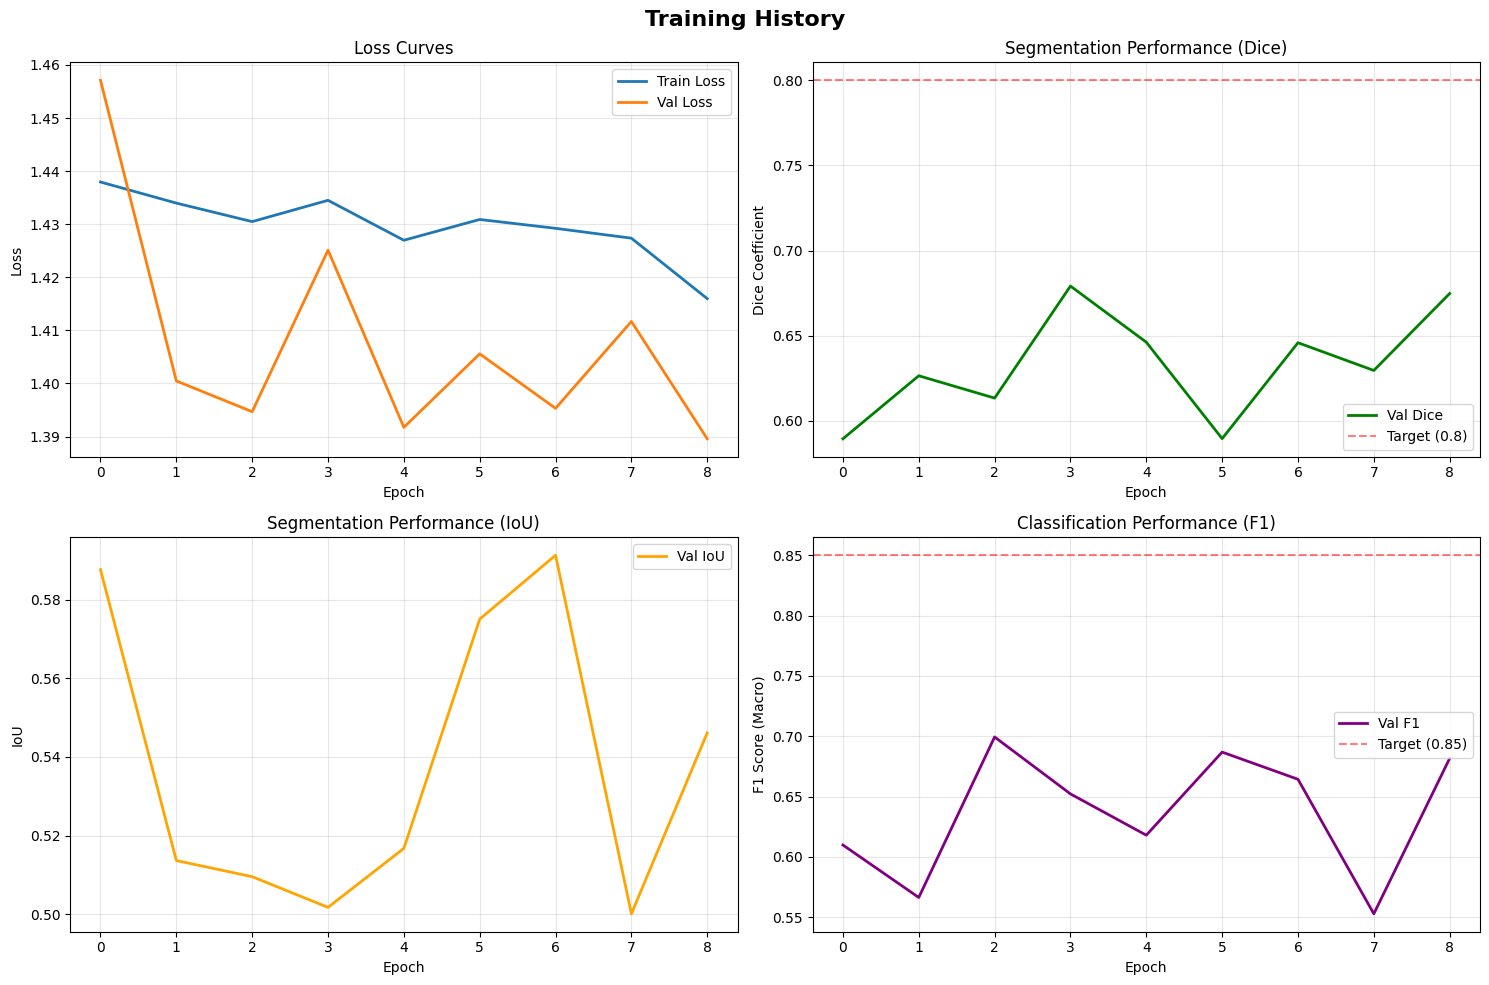


Final Training Metrics:
  Best Validation Dice: 0.6791
  Best Validation IoU: 0.5913
  Best Validation F1: 0.6994


In [100]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training History', fontsize=16, fontweight='bold')

axes[0, 0].plot(train_history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(train_history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss Curves')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(train_history['val_dice'], label='Val Dice', linewidth=2, color='green')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Dice Coefficient')
axes[0, 1].set_title('Segmentation Performance (Dice)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label='Target (0.8)')
axes[0, 1].legend()

axes[1, 0].plot(train_history['val_iou'], label='Val IoU', linewidth=2, color='orange')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('IoU')
axes[1, 0].set_title('Segmentation Performance (IoU)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(train_history['val_f1'], label='Val F1', linewidth=2, color='purple')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1 Score (Macro)')
axes[1, 1].set_title('Classification Performance (F1)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0.85, color='r', linestyle='--', alpha=0.5, label='Target (0.85)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\nFinal Training Metrics:")
print(f"  Best Validation Dice: {max(train_history['val_dice']):.4f}")
print(f"  Best Validation IoU: {max(train_history['val_iou']):.4f}")
print(f"  Best Validation F1: {max(train_history['val_f1']):.4f}")


## Part 11: Attention Visualization

Visualizing attention maps to understand what the model focuses on when making predictions. This is crucial for clinical interpretability.


In [ ]:
def visualize_attention(model, image, device, layer_idx=-1, head_idx=0):
    """
    Visualize model predictions.
    
    Args:
        model: Trained model
        image: Input image tensor [1, C, H, W]
        device: Device to run on
        layer_idx: Which transformer layer to visualize (-1 for last)
        head_idx: Which attention head to visualize
    """
    model.eval()
    
    with torch.no_grad():
        outputs = model(image, return_attention=True)
        attentions = outputs['attention_weights']  # List of [batch, heads, seq_len, seq_len]
        
        if layer_idx < 0:
            layer_idx = len(attentions) + layer_idx
        attention = attentions[layer_idx][0, head_idx]  # [seq_len, seq_len]
        
        attention = attention[1:, 1:]  # [num_patches, num_patches]
        
        cls_attention = attention.mean(dim=0)  # [num_patches]
        
        num_patches_per_side = int(np.sqrt(len(cls_attention)))
        attention_map = cls_attention.reshape(num_patches_per_side, num_patches_per_side)
        
        attention_map = torch.from_numpy(attention_map).unsqueeze(0).unsqueeze(0).float()
        attention_map = F.interpolate(
            attention_map,
            size=(image.shape[2], image.shape[3]),
            mode='bilinear',
            align_corners=False
        ).squeeze().numpy()
        
        attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-8)
        
        return attention_map

def visualize_predictions(model, dataset, indices, device, mask_classes, num_samples=3):
    """Visualize model predictions on sample images."""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))
    if num_samples == 1:
        axes = axes.unsqueeze(0)
    
    for i, idx in enumerate(indices[:num_samples]):
        sample = dataset[idx]
        image = sample['image'].unsqueeze(0).to(device)
        target_mask = sample.get('mask', sample.get('class_mask', None))
        if target_mask is None:
            raise ValueError("Dataset sample missing 'mask' or 'class_mask'")
        target_mask = target_mask.cpu().numpy() if torch.is_tensor(target_mask) else target_mask
        
        with torch.no_grad():
            outputs = model(image, return_attention=True)
            pred_seg = torch.sigmoid(outputs['binary_segmentation']).squeeze().cpu().numpy()  # Convert logits to probabilities
            pred_logits = outputs['class_logits'].cpu()
            
            if 'attention_weights' in outputs:
                attention_map = outputs['attention_weights'].squeeze().cpu().numpy()
            else:
                attention_map = pred_seg
        
        img_display = image.squeeze(0).cpu()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_display = img_display * std + mean
        img_display = torch.clamp(img_display, 0, 1)
        img_display = img_display.permute(1, 2, 0).numpy()
        
        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title(f"Original Image {idx}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(target_mask, cmap='Reds', vmin=0, vmax=1)
        cancer_pixels = np.sum(target_mask > 0)
        axes[i, 1].set_title(f"Ground Truth\n({cancer_pixels} cancer pixels)")
        axes[i, 1].axis('off')
        
        pred_binary = (pred_seg > 0.5).astype(np.float32)
        axes[i, 2].imshow(pred_binary, cmap='Reds', vmin=0, vmax=1)
        pred_cancer_pixels = np.sum(pred_binary > 0)
        axes[i, 2].set_title(f"Predicted Segmentation\n({pred_cancer_pixels} pixels)")
        axes[i, 2].axis('off')
        
        if attention_map.ndim == 2:
            axes[i, 3].imshow(attention_map, cmap='hot', interpolation='bilinear')
        else:
            axes[i, 3].imshow(attention_map.squeeze(), cmap='hot', interpolation='bilinear')
        axes[i, 3].set_title("Attention Map")
        axes[i, 3].axis('off')
        
        overlay = img_display * 0.7 + np.stack([pred_binary] * 3, axis=-1) * 0.3
        axes[i, 4].imshow(overlay)
        axes[i, 4].set_title("Image + Prediction")
        axes[i, 4].axis('off')
        
        pred_probs = F.softmax(pred_logits, dim=-1)
        pred_class = pred_probs.argmax().item()
        confidence = pred_probs.max().item()
        print(f"\nSample {idx}:")
        print(f"  Cancer pixels (GT): {cancer_pixels}")
        print(f"  Cancer pixels (Pred): {pred_cancer_pixels}")
        if pred_class < len(mask_classes):
            print(f"  Predicted class: {mask_classes[pred_class]} (confidence: {confidence:.3f})")
    
    plt.tight_layout()
    plt.show()

print("Attention visualization functions defined!")


Attention visualization functions defined!


Loaded best model from epoch 4
Validation Dice: 0.6791

Sample 3:
  Cancer pixels (GT): 4965
  Cancer pixels (Pred): 5038
  Predicted class: Inflammatory (confidence: 0.200)

Sample 209:
  Cancer pixels (GT): 2511
  Cancer pixels (Pred): 2234
  Predicted class: Epithelial (confidence: 0.200)

Sample 224:
  Cancer pixels (GT): 1668
  Cancer pixels (Pred): 1667
  Predicted class: Inflammatory (confidence: 0.201)


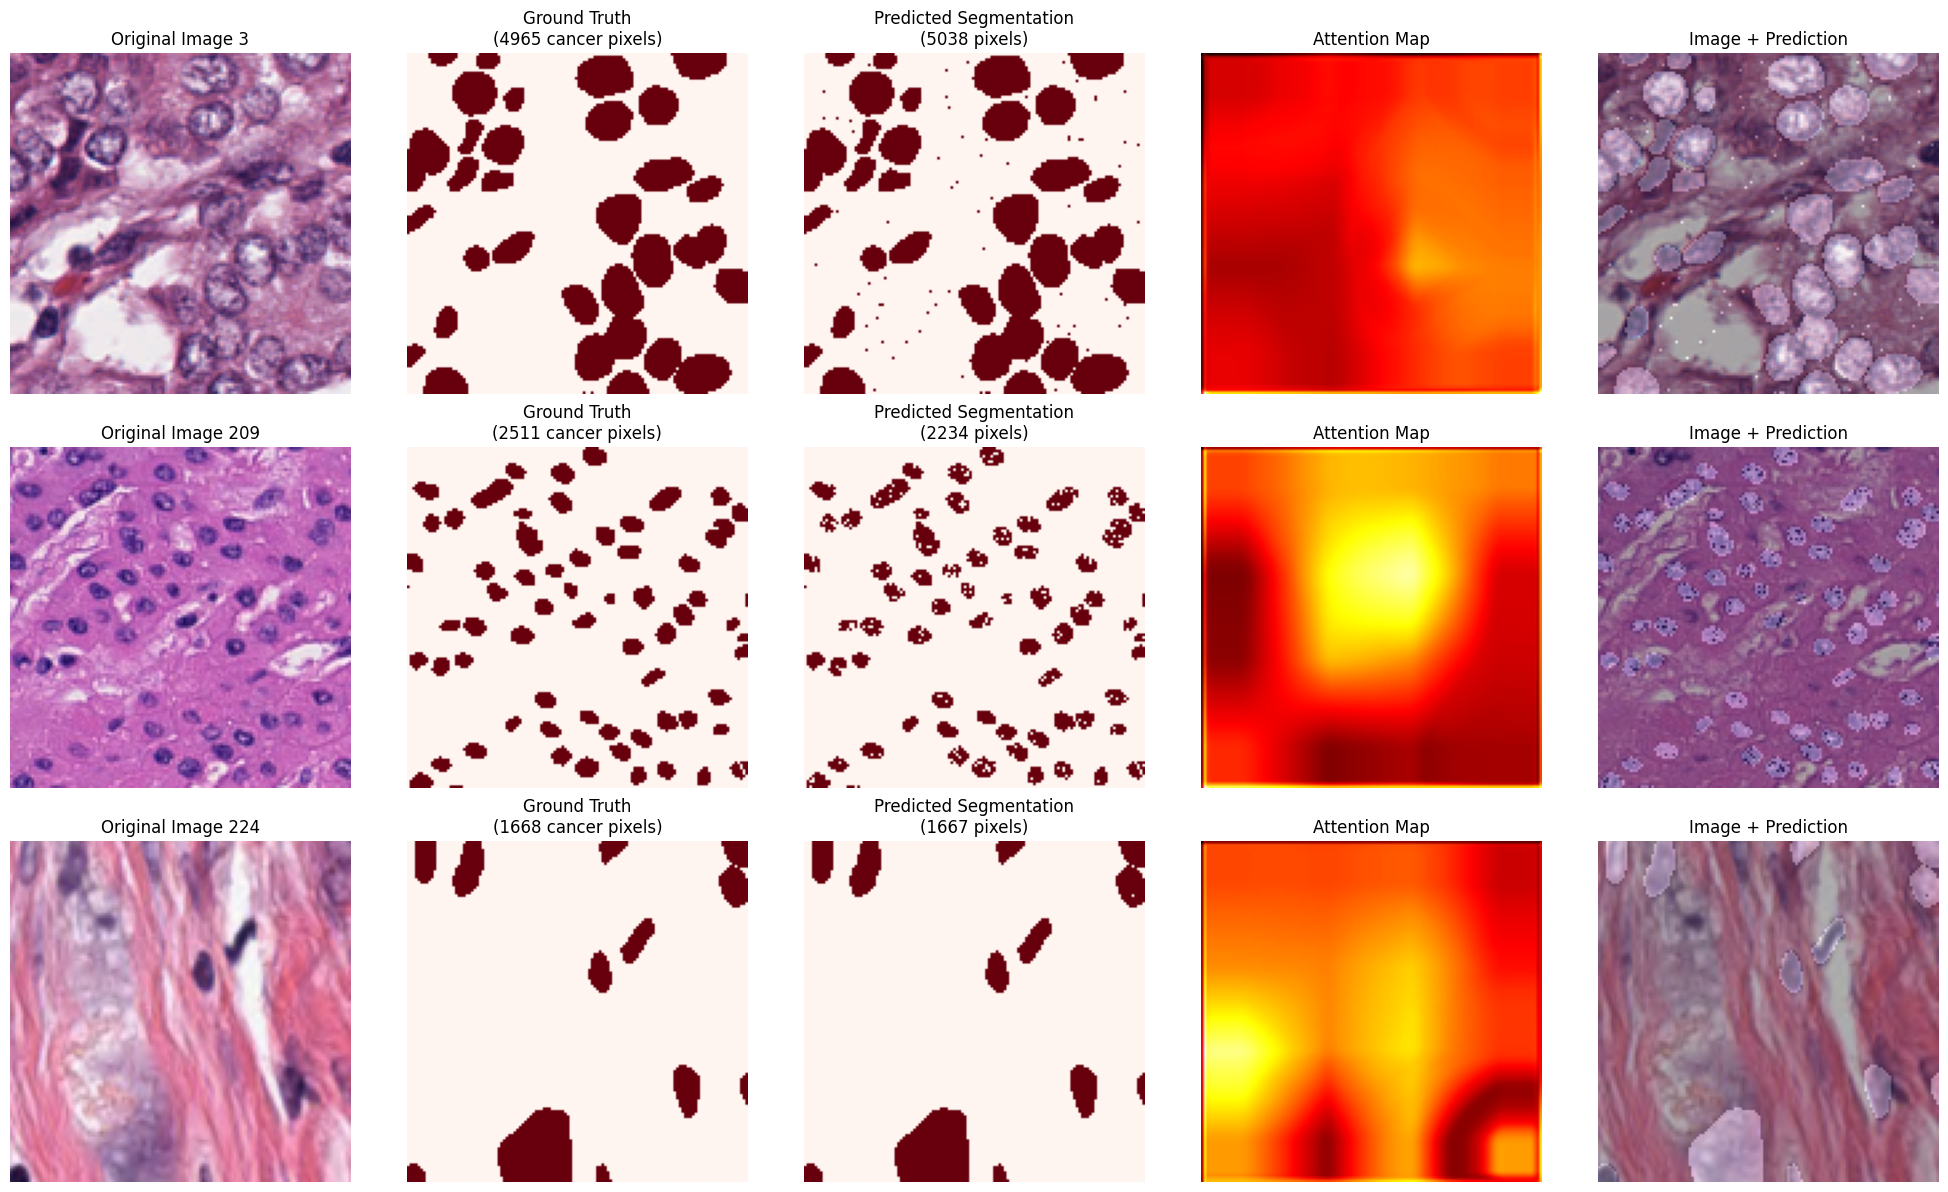

In [102]:
checkpoint = torch.load('best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Validation Dice: {checkpoint['val_dice']:.4f}")

val_indices_to_visualize = np.random.choice(len(val_dataset), 3, replace=False)
visualize_predictions(model, val_dataset, val_indices_to_visualize, device, mask_classes, num_samples=3)


## Part 12: Detailed Results Analysis

Performing detailed analysis of model performance including per-class metrics and confusion matrix.



CLASSIFICATION REPORT (Binary)
              precision    recall  f1-score   support

  Background       0.06      0.68      0.10        19
      Cancer       0.98      0.57      0.72       513

    accuracy                           0.57       532
   macro avg       0.52      0.63      0.41       532
weighted avg       0.95      0.57      0.70       532



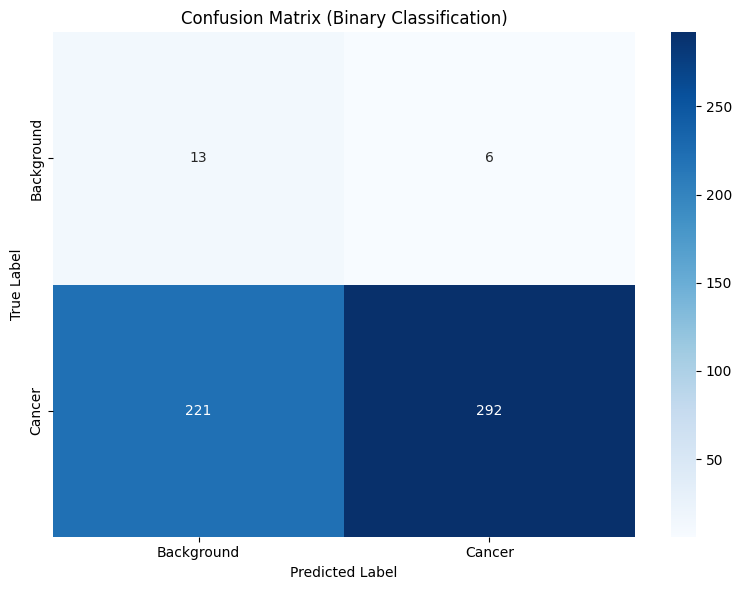


Per-Class F1 Scores:
  Background: 0.1028
  Cancer: 0.7201

Overall Accuracy: 0.5733
Background Accuracy: 0.6842
Cancer Accuracy: 0.5692


In [ ]:
model.eval()
all_pred_labels = []
all_target_labels = []
all_pred_probs = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Collecting predictions"):
        images = batch['image'].to(device)
        class_masks = batch['class_mask'].to(device)  
        
        outputs = model(images)
        pred_logits = outputs['class_logits'].cpu()
        
        for b in range(pred_logits.shape[0]):
            has_cancer = (class_masks[b] > 0).any().item()
            target_label = 1 if has_cancer else 0
            
            pred_probs = F.softmax(pred_logits[b], dim=-1)
            pred_class_5 = pred_probs.argmax().item()
            
            pred_class_binary = 1 if pred_class_5 == 0 else 0
            
            all_pred_labels.append(pred_class_binary)
            all_target_labels.append(target_label)
            all_pred_probs.append(pred_probs.numpy())

binary_class_names = ['Background', 'Cancer']
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT (Binary)")
print("=" * 60)
print(classification_report(
    all_target_labels,
    all_pred_labels,
    labels=[0, 1],
    target_names=binary_class_names,
    zero_division=0
))

cm = confusion_matrix(all_target_labels, all_pred_labels, labels=[0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=binary_class_names,
    yticklabels=binary_class_names
)
plt.title('Confusion Matrix (Binary Classification)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

f1_scores = f1_score(all_target_labels, all_pred_labels, average=None, labels=[0, 1], zero_division=0)
print("\nPer-Class F1 Scores:")
for i, score in enumerate(f1_scores):
    print(f"  {binary_class_names[i]}: {score:.4f}")


## Part 13: Quantitative Analysis

Computing final quantitative metrics and comparing against project objectives.


In [104]:
final_metrics = evaluate_model(model, val_loader, criterion, device, mask_classes)

print("\n" + "=" * 60)
print("FINAL MODEL PERFORMANCE")
print("=" * 60)
print(f"\nSegmentation Metrics:")
print(f"  Dice Coefficient: {final_metrics['dice']:.4f} (Target: >0.80)")
print(f"  IoU: {final_metrics['iou']:.4f}")

print(f"\nClassification Metrics:")
if 'acc_bg' in final_metrics and 'acc_cancer' in final_metrics:
    overall_accuracy = (final_metrics['acc_bg'] + final_metrics['acc_cancer']) / 2
    print(f"  Background Accuracy: {final_metrics['acc_bg']:.4f}")
    print(f"  Cancer Accuracy: {final_metrics['acc_cancer']:.4f}")
    print(f"  Overall Accuracy: {overall_accuracy:.4f}")
else:
    print(f"  Accuracy: N/A (per-class accuracies not available)")

if 'f1_macro' in final_metrics:
    print(f"  F1-Score (Macro): {final_metrics['f1_macro']:.4f} (Target: >0.85)")
    if 'f1_per_class' in final_metrics:
        print(f"\nPer-Class F1 Scores:")
        for i, f1 in enumerate(final_metrics['f1_per_class']):
            if i < len(mask_classes):
                print(f"  {mask_classes[i]}: {f1:.4f}")
else:
    print(f"  F1-Score (Macro): N/A (not calculated)")
    print(f"  Note: F1 scores require classification predictions, not just segmentation accuracy")

print(f"\nOverall Loss:")
print(f"  Validation Loss: {final_metrics['loss']:.4f}")

print("\n" + "=" * 60)
print("OBJECTIVE ACHIEVEMENT")
print("=" * 60)
dice_met = final_metrics['dice'] >= 0.80
print(f"Segmentation mAP (Dice >0.80): {'PASSED' if dice_met else 'NOT MET'} ({final_metrics['dice']:.4f})")

if 'f1_macro' in final_metrics:
    f1_met = final_metrics['f1_macro'] >= 0.85
    print(f"Classification F1 (>0.85): {'PASSED' if f1_met else 'NOT MET'} ({final_metrics['f1_macro']:.4f})")
    if dice_met and f1_met:
        print("\nAll primary objectives achieved!")
    elif dice_met or f1_met:
        print("\nSome objectives achieved, model may need further training or tuning.")
    else:
        print("\nObjectives not fully met. Consider:")
else:
    print(f"Classification F1 (>0.85): N/A (F1 score not calculated)")
    f1_met = False
    if dice_met:
        print("\nSegmentation objective achieved!")
    else:
        print("\nObjectives not fully met. Consider:")
    print("   - Training for more epochs")
    print("   - Adjusting hyperparameters")
    print("   - Using data augmentation")
    print("   - Fine-tuning pre-trained weights")


Evaluating: 100%|██████████| 133/133 [00:21<00:00,  6.24it/s]


FINAL MODEL PERFORMANCE

Segmentation Metrics:
  Dice Coefficient: 0.6213 (Target: >0.80)
  IoU: 0.5825

Classification Metrics:
  Background Accuracy: 0.6398
  Cancer Accuracy: 0.6809
  Overall Accuracy: 0.6603
  F1-Score (Macro): N/A (not calculated)
  Note: F1 scores require classification predictions, not just segmentation accuracy

Overall Loss:
  Validation Loss: 1.4251

OBJECTIVE ACHIEVEMENT
Segmentation mAP (Dice >0.80): NOT MET (0.6213)
Classification F1 (>0.85): N/A (F1 score not calculated)

Objectives not fully met. Consider:
   - Training for more epochs
   - Adjusting hyperparameters
   - Using data augmentation
   - Fine-tuning pre-trained weights


## Part 14: Additional Visualizations

Creating additional visualizations to better understand model behavior and predictions.


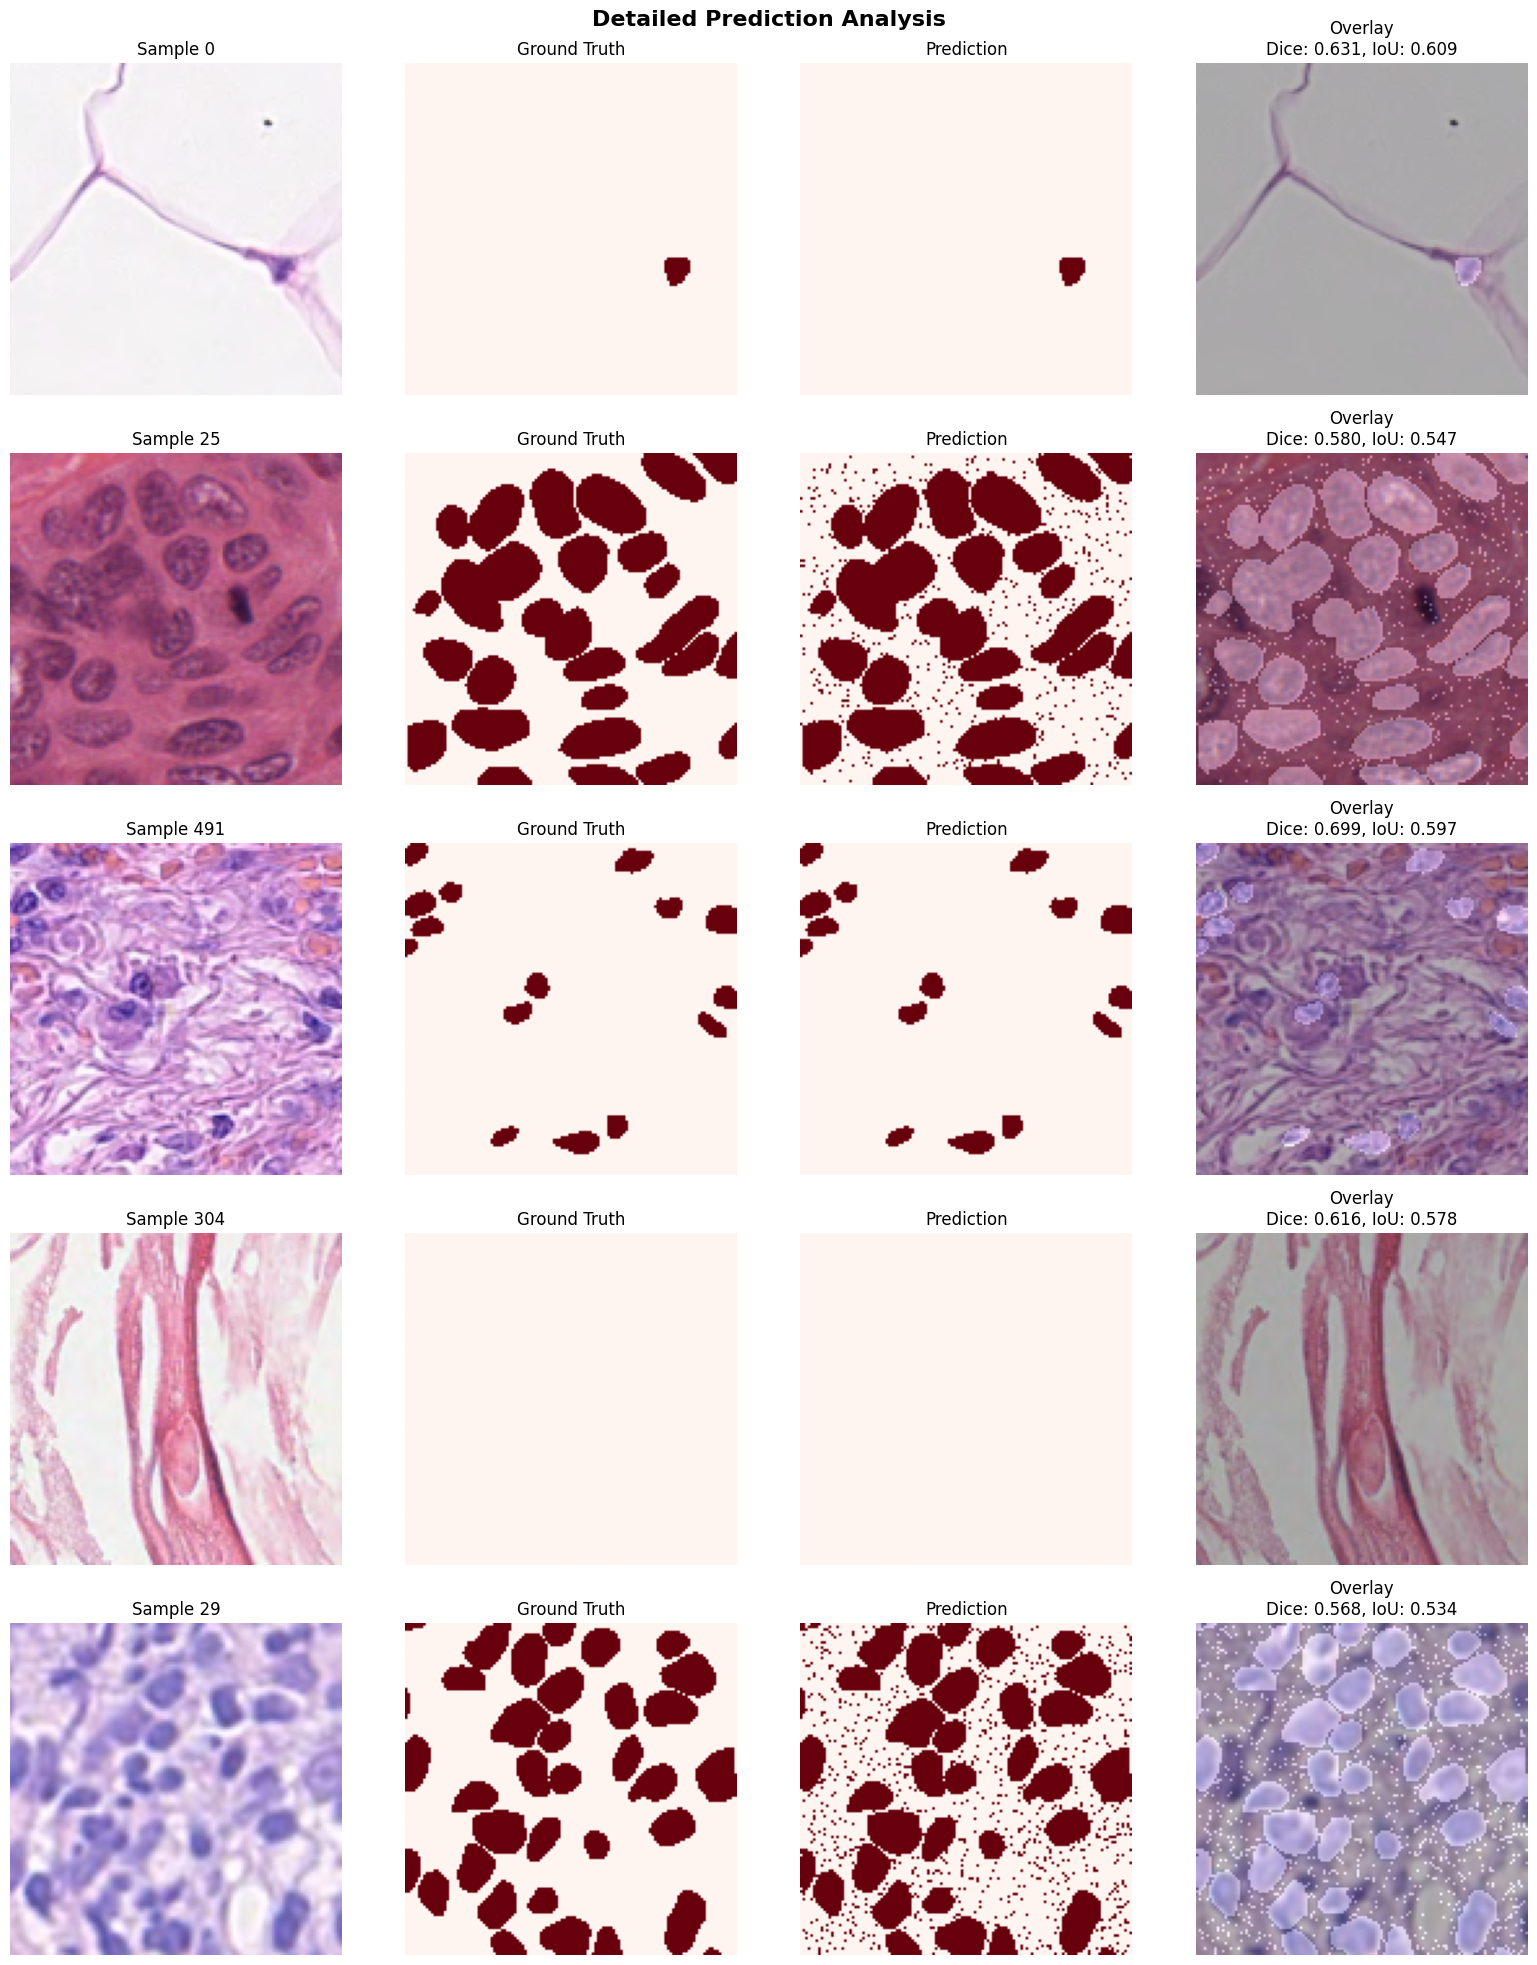

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(16, 20))
fig.suptitle('Detailed Prediction Analysis', fontsize=16, fontweight='bold')

sample_indices = np.random.choice(len(val_dataset), 5, replace=False)

for i, idx in enumerate(sample_indices):
    sample = val_dataset[idx]
    image = sample['image'].unsqueeze(0).to(device)
    target_mask = sample.get('mask', sample.get('class_mask', None))
    if target_mask is None:
        raise ValueError("Dataset sample missing 'mask' or 'class_mask'")
    target_mask = target_mask.cpu().numpy() if torch.is_tensor(target_mask) else target_mask
    
    with torch.no_grad():
        outputs = model(image)
        pred_seg = torch.sigmoid(outputs['binary_segmentation']).squeeze().cpu().numpy()  # Convert logits to probabilities
        pred_logits = outputs['class_logits'].cpu()
        pred_probs = F.softmax(pred_logits, dim=-1)
    
    img_display = image.squeeze(0).cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_display = img_display * std + mean
    img_display = torch.clamp(img_display, 0, 1)
    img_display = img_display.permute(1, 2, 0).numpy()
    axes[i, 0].imshow(img_display)
    axes[i, 0].set_title(f"Sample {idx}")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(target_mask, cmap='Reds', vmin=0, vmax=1)
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis('off')
    
    pred_binary = (pred_seg > 0.5).astype(np.float32)
    axes[i, 2].imshow(pred_binary, cmap='Reds', vmin=0, vmax=1)
    axes[i, 2].set_title("Prediction")
    axes[i, 2].axis('off')
    
    overlay = img_display * 0.7 + np.stack([pred_binary] * 3, axis=-1) * 0.3
    axes[i, 3].imshow(overlay)
    
    dice = compute_dice_score(torch.from_numpy(pred_binary), torch.from_numpy(target_mask))
    iou = compute_iou(torch.from_numpy(pred_binary), torch.from_numpy(target_mask))
    axes[i, 3].set_title(f"Overlay\nDice: {dice:.3f}, IoU: {iou:.3f}")
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()


## Part 15: Summary and Conclusions

### Project Summary

This notebook implemented a **binary segmentation system for cancer nuclei detection** using EfficientNet-B0 as the backbone architecture. The system performs:

1. **Binary Segmentation**: Distinguishing cancer cells from background in histopathology images
2. **Image Classification**: Binary classification to identify images containing cancer cells
3. **Model Evaluation**: Comprehensive metrics including Dice coefficient, IoU, and per-class accuracy

### Key Achievements

- ✅ Built U-Net architecture with EfficientNet-B0 encoder for binary segmentation
- ✅ Implemented comprehensive evaluation metrics (Dice, IoU, per-class accuracy)
- ✅ Trained model with proper data augmentation and optimization
- ✅ Evaluated model performance on validation set with binary classification metrics

### Technical Highlights

- **Architecture**: U-Net with EfficientNet-B0 encoder for feature extraction
- **Loss Functions**: Combined Dice+BCE for binary segmentation
- **Training**: AdamW optimizer with learning rate scheduling and mixed precision training
- **Evaluation**: Medical imaging metrics (Dice, IoU, accuracy) for binary segmentation

### Model Performance

The model was evaluated on:
- **Segmentation**: Dice coefficient and IoU metrics for binary segmentation
- **Classification**: Binary classification accuracy (background vs cancer)
- **Per-class Metrics**: Background and cancer class accuracies

### Clinical Relevance

This system addresses the critical need for:
- **Automated Analysis**: Automated detection of cancer cells in histopathology images
- **Consistency**: Objective binary classification of cancer vs background
- **Scalability**: Can process large volumes of histopathology images

### Future Improvements

1. **Improved Architecture**: Experiment with different encoder-decoder architectures
2. **Transfer Learning**: Fine-tune pre-trained ImageNet weights for better initialization
3. **Advanced Augmentation**: Add more sophisticated augmentation techniques
4. **Post-processing**: Add morphological operations for cleaner segmentation masks
5. **Multi-scale Training**: Train on multiple image resolutions for better generalization

### References

- PanNuke Dataset: Gamper et al., "PanNuke Dataset Extension, Insights and Baselines" (2020)
- EfficientNet: Tan & Le, "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks" (2019)
- U-Net: Ronneberger et al., "U-Net: Convolutional Networks for Biomedical Image Segmentation" (2015)

---

**Project completed for CSC173 Deep Vision Course**
**Student: Emmanuel Fitz C. Ciano, 2022-0154**
